# 1. Set up the notebook

## 1.1 Import modules

In [2]:
import json
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from IPython.display import display, IFrame, HTML

## 1.2 Define data loaders

Define a function to load flight data from hardware experiments and resample it at 100 Hz using linear interpolation.

In [3]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [4]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

## 1.3 Define an LQR solver

Here is a function that solves the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [5]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

## 1.4 Define autoencoders

Here is a function to print code that implements linear state feedback.

In [6]:
def export_controller(K, s, i, s_with_des, i_eq,
                      decimals=8,
                      suffix='',
                      line_ending=''):
    """
    K is a gain matrix, of size m x n
    s is a list of states as symbolic variables, of length n
    i is a list of inputs as symbolic variables, of length m
    s_with_des is a list of states that have desired values, as
        symbolic variables - if there are no such states, then
        this should be an empty list []
    i_eq is a list of equilibrium values of inputs, of length m
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    s_name = [scur.name for scur in s]
    i_name = [icur.name for icur in i]
    for row in range(len(i_name)):
        input_string = ''
        for col in range(len(s_name)):
            k = K[row, col]
            if not np.isclose(k, 0.):
                if (k < 0) and input_string:
                    input_string += ' +'
                if s[col] in s_with_des:
                    n = f'({s_name[col]} - {s_name[col]}_des)'
                else:
                    n = s_name[col]
                input_string += f' {-k:.{decimals}f}{suffix} * {n}'
        if not np.isclose(i_eq[row], 0.):
            if (i_eq[row] > 0) and input_string:
                input_string += ' +'
            input_string += f' {i_eq[row]:.{decimals}f}{suffix}'
        print(f'{i_name[row]} ={input_string}{line_ending}')

Here is a function to print code that implements a method of power distribution.

In [7]:
def export_power_distribution(Pinv,
                              limiter='self.limitUint16',
                              decimals=1,
                              suffix='',
                              line_ending=''):
    """
    Pinv is a 4 x 4 matrix that maps inputs (tau_x, tau_y, tau_z, f_z)
        to motor power commands (m_1, m_2, m_3, m_4)
    limiter is the name of the function to apply that ensures each
        motor power command is valid (i.e., an integer within bounds),
        for example "limitUint16" when exporting to C
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    i_name = ['tau_x', 'tau_y', 'tau_z', 'f_z']
    m_name = ['m_1', 'm_2', 'm_3', 'm_4']
    for row in range(len(m_name)):
        input_string = ''
        for col in range(len(i_name)):
            k = Pinv[row, col]
            if not np.isclose(k, 0.):
                if (k > 0) and input_string:
                    input_string += ' +'
                n = i_name[col]
                input_string += f' {k:.{decimals}f}{suffix} * {n}'
        print(f'{m_name[row]} = {limiter}({input_string} ){line_ending}')

## 1.6 Observability matrix

Define a function to create the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ has size $n \times n$.

In [8]:
def obsv(A, C):
    W = C
    for i in range(1, A.shape[0]):
        W = np.vstack([W, C @ np.linalg.matrix_power(A, i)])
    return W

# 2. Define constants

Define the acceleration of gravity in $\text{kg}\cdot\text{m} \;/\; \text{s}^2$:

In [9]:
g = 9.81

Define the mass of the drone in $\text{kg}$:

In [10]:
m = m_val = 35.9 / 1000.

# 3. Estimate the moments of inertia

## 3.1 Estimate the moment of inertia about the 𝑥-axis

Define the distance in meters between the axis of rotation and the center of mass:

In [11]:
r = 3.0 / 100
# 1.25 inches

Load and resample data.

The `load_hardware_data` function has two optional arguments:

* `t_min_offset` allows you to discard data at the *start* of the experiment - if its value is `4.`, for example, then the *first* four seconds of data will be discarded
* `t_max_offset` allows you to discard data at the *end* of the experiment - if its value is `4.`, for example, then the *last* four seconds of data will be discarded


In [12]:
data = load_hardware_data(
    'results/x_data.json',
    t_min_offset=5.,
    t_max_offset=0.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [13]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $x$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

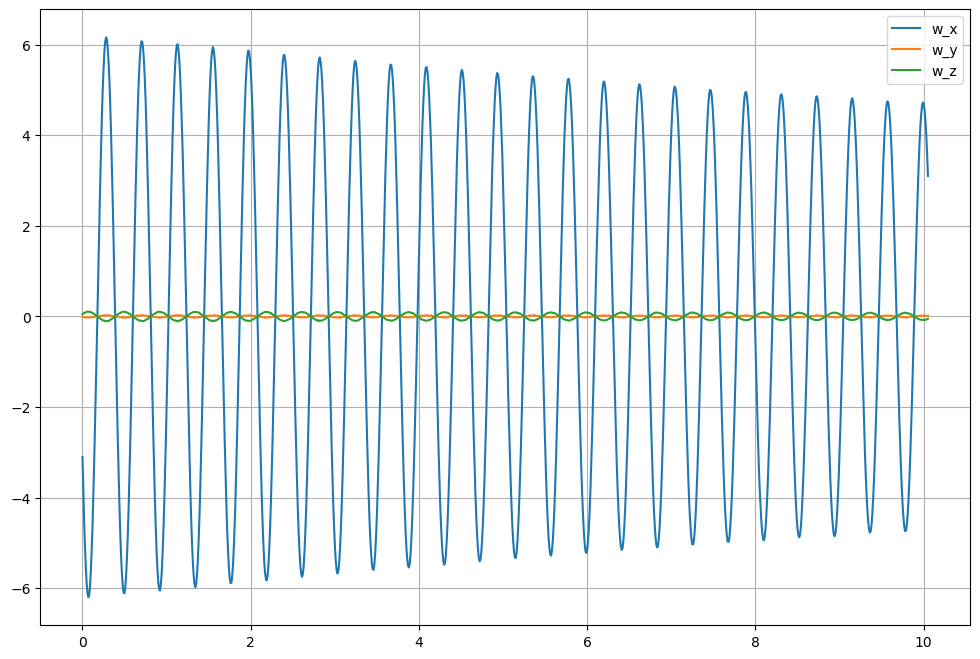

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

You should find that `w_x` is oscillatory. The period is the peak-to-peak time. You could measure the period by hand, but it is easier to automate this process, particularly if you want to average your estimate of the period over many oscillations.

Here is one way to do it:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.

Here is one way to implement this in code, using [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html):

In [15]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_x, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_x_peaks = w_x[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

Sanity check - print the peak times:

In [16]:
print(t_peaks)

[0.28 0.7  1.13 1.55 1.97 2.4  2.82 3.24 3.66 4.09 4.51 4.93 5.35 5.78
 6.2  6.62 7.04 7.46 7.89 8.31 8.73 9.15 9.57 9.99]


Sanity check - plot the peaks:

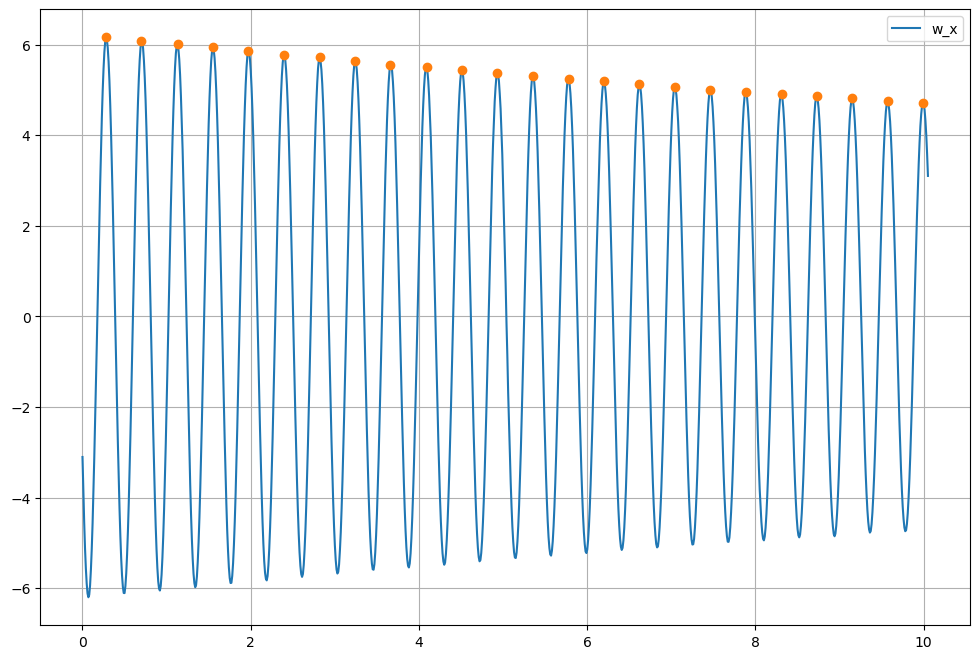

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t_peaks, w_x_peaks, '.', markersize=12)
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [18]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')

time differences: [0.42 0.43 0.42 0.42 0.43 0.42 0.42 0.42 0.43 0.42 0.42 0.42 0.43 0.42
 0.42 0.42 0.42 0.43 0.42 0.42 0.42 0.42 0.42]

period estimate (i.e., mean time difference): T = 0.4222


Compute the moment of inertia about the $x$ axis (see formula from theory).

In [19]:
J_x = J_x_val = m*g*r / (2*np.pi / T)**2 - m*r**2 
J_x

1.5388833881328005e-05

## 3.2 Estimate the moment of inertia about the $y$-axis

Define the distance in meters between the axis of rotation and the center of mass:

In [20]:
r = 3.0 / 100 
# 1.25 inches

Load and resample data.

The `load_hardware_data` function has two optional arguments:

* `t_min_offset` allows you to discard data at the *start* of the experiment - if its value is `4.`, for example, then the *first* four seconds of data will be discarded
* `t_max_offset` allows you to discard data at the *end* of the experiment - if its value is `4.`, for example, then the *last* four seconds of data will be discarded

In [21]:
data_y = load_hardware_data(
    'results/y_data.json',
    t_min_offset=5.,
    t_max_offset=0.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [22]:
t = data_y['time']
w_x = np.deg2rad(data_y['gyro.x'])
w_y = np.deg2rad(data_y['gyro.y'])
w_z = np.deg2rad(data_y['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $y$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

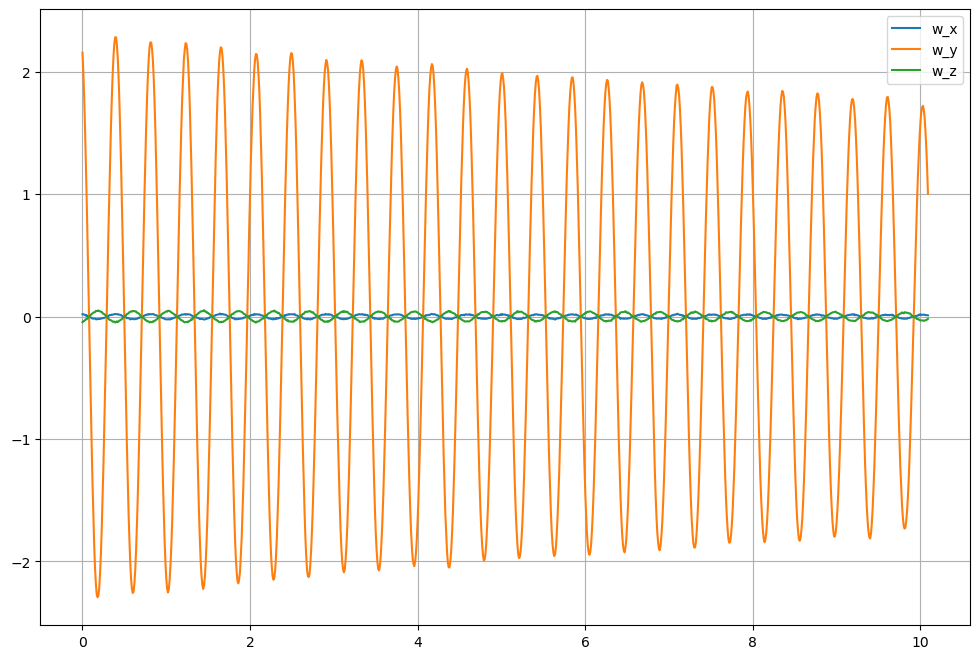

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

You should find that `w_y` is oscillatory. The period is the peak-to-peak time. You could measure the period by hand, but it is easier to automate this process, particularly if you want to average your estimate of the period over many oscillations.

Here is one way to do it:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.

Here is one way to implement this in code, using [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html):

In [24]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_y, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_y_peaks = w_y[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

Sanity check - print the peak times:

In [25]:
print(t_peaks)

[ 0.4   0.81  1.23  1.65  2.07  2.49  2.91  3.33  3.75  4.17  4.59  5.01
  5.43  5.85  6.26  6.68  7.1   7.51  7.94  8.35  8.77  9.19  9.61 10.03]


Sanity check - plot the peaks:

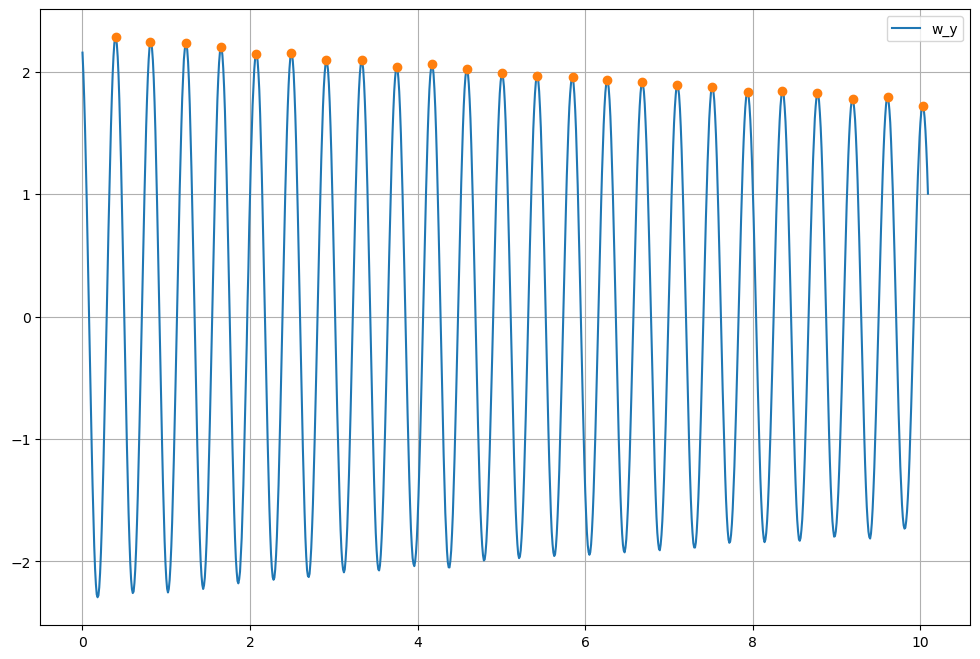

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_y, label='w_y')
plt.plot(t_peaks, w_y_peaks, '.', markersize=12)
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [27]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')

time differences: [0.41 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.41
 0.42 0.42 0.41 0.43 0.41 0.42 0.42 0.42 0.42]

period estimate (i.e., mean time difference): T = 0.4187


Add cells here to repeat the same process as above...

In [28]:
J_y = J_y_val = m*g*r / (2*np.pi / T)**2 - m*r**2 
J_y

1.4606097070124496e-05

# 3.3 Estimate the moment of inertia about the $z$-axis

Define the distance in meters between the axis of rotation and the center of mass:

In [29]:
# Radius from where nail is to center of drone
r = 1.5 / 100

Load and resample data.

The `load_hardware_data` function has two optional arguments:

* `t_min_offset` allows you to discard data at the *start* of the experiment - if its value is `4.`, for example, then the *first* four seconds of data will be discarded
* `t_max_offset` allows you to discard data at the *end* of the experiment - if its value is `4.`, for example, then the *last* four seconds of data will be discarded


In [30]:
data_z = load_hardware_data(
    'results/z_data.json',
    t_min_offset=0.,
    t_max_offset=8.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [31]:
t = data_z['time']
w_x = np.deg2rad(data_z['gyro.x'])
w_y = np.deg2rad(data_z['gyro.y'])
w_z = np.deg2rad(data_z['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $z$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

In our case, the component in the y and x direction are NOT negligible. This is a source of error on $J_z$

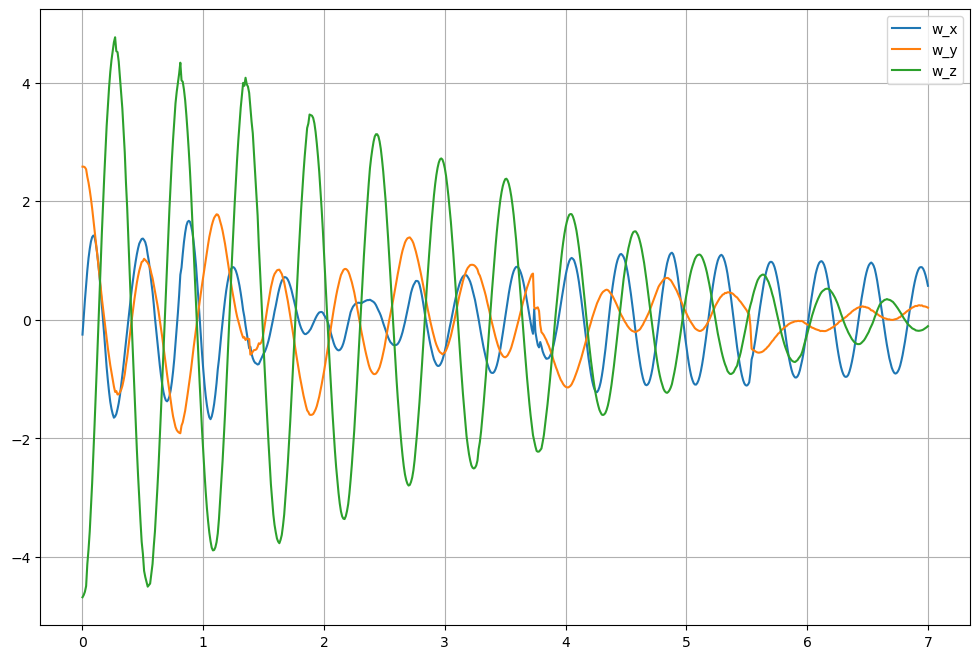

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

 `w_z` is oscillatory. The period is the peak-to-peak time.

Here is one way to automate the period finding process:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.

Here is one way to implement this in code, using [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html):

In [33]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_z, prominence=0.05)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_z at each peak (for visualization)
w_z_peaks = w_z[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

Sanity check - print the peak times:

In [34]:
print(t_peaks)

[0.27 0.81 1.35 1.88 2.43 2.97 3.51 4.04 4.58 5.11 5.63 6.17 6.66]


Sanity check - plot the peaks:

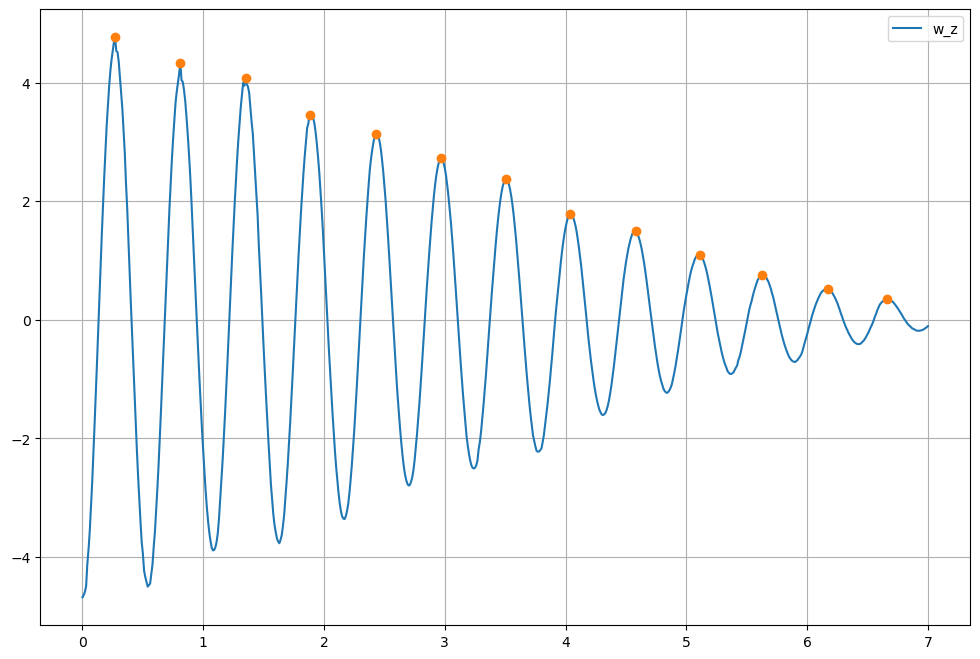

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_z, label='w_z')
plt.plot(t_peaks, w_z_peaks, '.', markersize=12)
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [36]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')

time differences: [0.54 0.54 0.53 0.55 0.54 0.54 0.53 0.54 0.53 0.52 0.54 0.49]

period estimate (i.e., mean time difference): T = 0.5325


Add cells here to repeat the same process as above...

In [37]:
J_z = J_z_val = m*g*r / (2*np.pi / T)**2 - m*r**2 
print("J_z: ", J_z)

J_z:  2.9865721624108755e-05


# 4. Find the force parameter

## 4.1 Force flight

In order to estimate the force coefficient, it is necessary to fly the drone near hover while varying the total force from the rotors. At this position, it can be assumed that the x and y components of both linear and angular velocity are close to zero. The approach taken in this experiment was to instruct the drone to fly up and down along a vertical line. The following sequence of move commands was run in the client code to produce these results:

```python
distance = 0.05
height = 0.55
for i in range(0, 15) :
    # Move up from hover by [distance] meters:
    client.move(0.0, 0.0, height + distance, 0.0, 1.0)
    # Move down from hover by [distance] meters:
    client.move(0.0, 0.0, height - distance, 0.0, 1.0)
    # Return to hover at [height] meters:
    client.move(0.0, 0.0, height, 0.0, 1.0)
    # Increase distance
    distance += 0.03
```

Here, height represents the target hover altitude, and distance represents the increasing deviation from the target hover altitude.

### 4.2 Get and plot flight data

Load and resample data.

In [38]:
data = load_hardware_data(
    'results/force-data.json',
    t_min_offset=4.,
    t_max_offset=4.,
)

Parse data to get:
* time
* the accelerometer measurements (**note!** these are in units of "g's")
* the motor power commands

In [39]:
t = data['time']
a_x = g * data['acc.x']
a_y = g * data['acc.y']
a_z = g * data['acc.z']
m_1 = data['motor.m1']
m_2 = data['motor.m2']
m_3 = data['motor.m3']
m_4 = data['motor.m4']

Plot accelerometer measurements and motor power commands. Since the rotors generate force only in the body-fixed $z$ direction, the $x$ and $y$ accelerometer measurements should be much smaller than the $z$ accelerometer measurements. It is important to check this. (Also remember to use `t_min_offset` and `t_max_offset` so that you only look at data from when you are *actually flying.*)

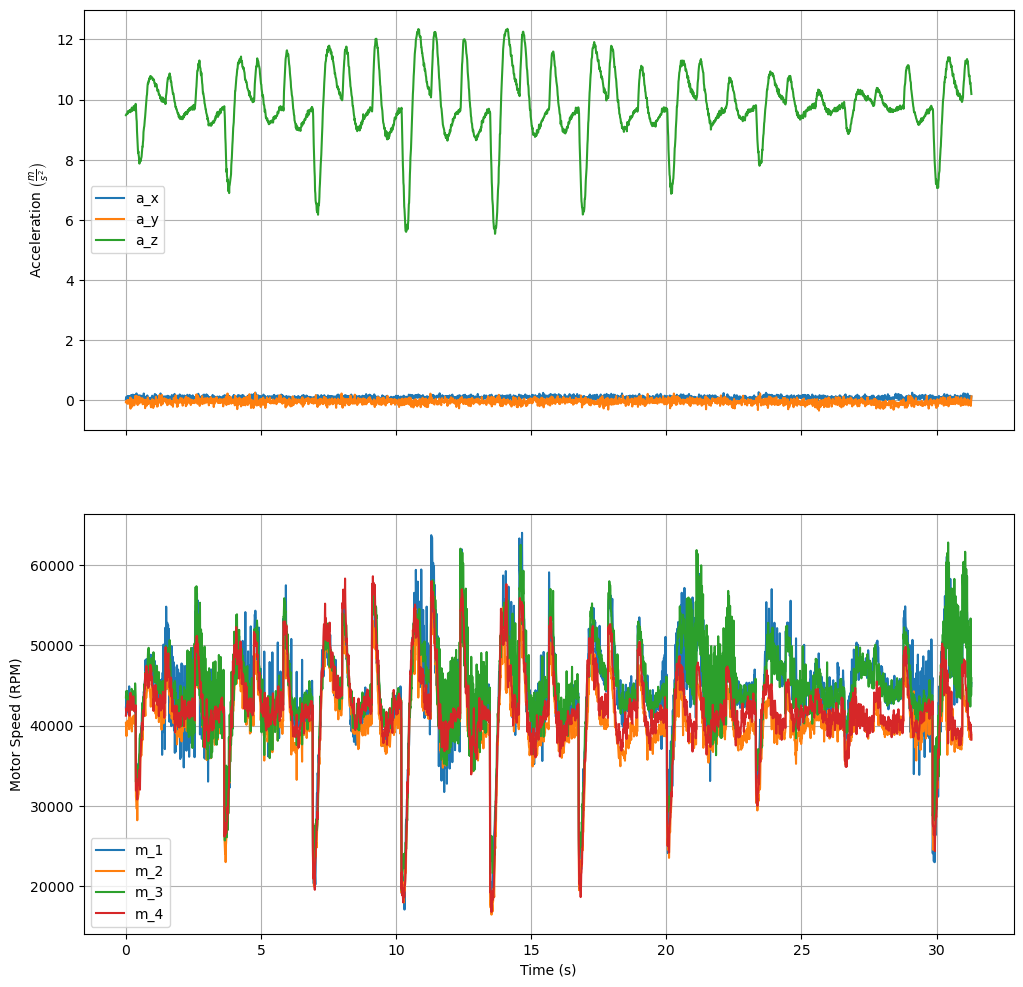

In [40]:
fig, (ax_a, ax_m) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax_a.plot(t, a_x, label='a_x')
ax_a.plot(t, a_y, label='a_y')
ax_a.plot(t, a_z, label='a_z')
ax_a.legend()
ax_a.grid()
ax_a.set_ylabel(r"Acceleration $\left(\frac{m}{s^2}\right)$")
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.set_ylabel('Motor Speed (RPM)')
ax_m.set_xlabel('Time (s)')
ax_m.legend()
ax_m.grid()

### 4.3 Apply linear regression to estimate $k_F$

First, compute `x`.

In [41]:
x = m_1 + m_2 + m_3 + m_4
x_filter = np.where(x > 90000)
x_filtered = x[x_filter]

Second, compute `y`.

In [42]:
y = m * a_z
y_filtered = y[x_filter]

Third, compute `c_est`.

In [43]:
c_est = np.sum(y_filtered * x_filtered) / np.sum(x_filtered**2)

Finally, compute `k_F` in terms of `c_est`.

In [44]:
k_F = c_est

Show the estimate.

In [45]:
print(f'k_F = {k_F:.4e}')

k_F = 2.0428e-06


### 4.4 Validate your estimate

Compare the linear fit to the raw data.

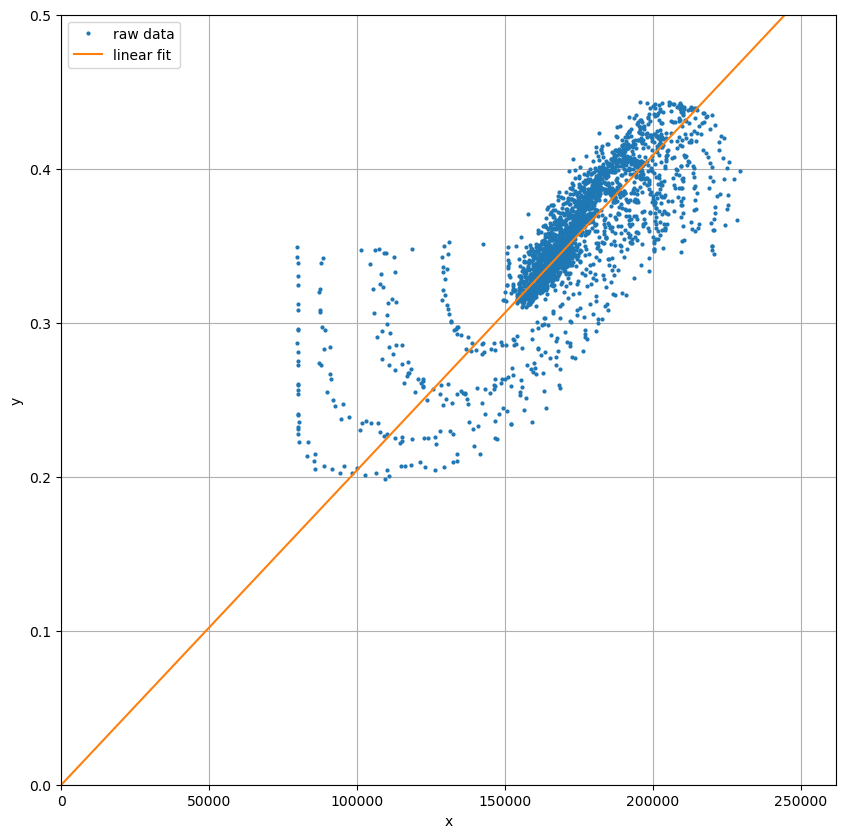

In [46]:
plt.figure(figsize=(10, 10))
plt.plot(x, y, '.', markersize=4, label='raw data')
plt.plot([0, 262140], [c_est * 0, c_est * 262140], label='linear fit')
plt.xlim(0, 262140)
plt.xlabel('x')
plt.ylim(0, 0.5)
plt.ylabel('y')
plt.grid()
plt.legend()

Compare the z-axis accelerometer measurement to what you would have predicted with your estimate of $k_F$.

Text(0.5, 0, 'Time (s)')

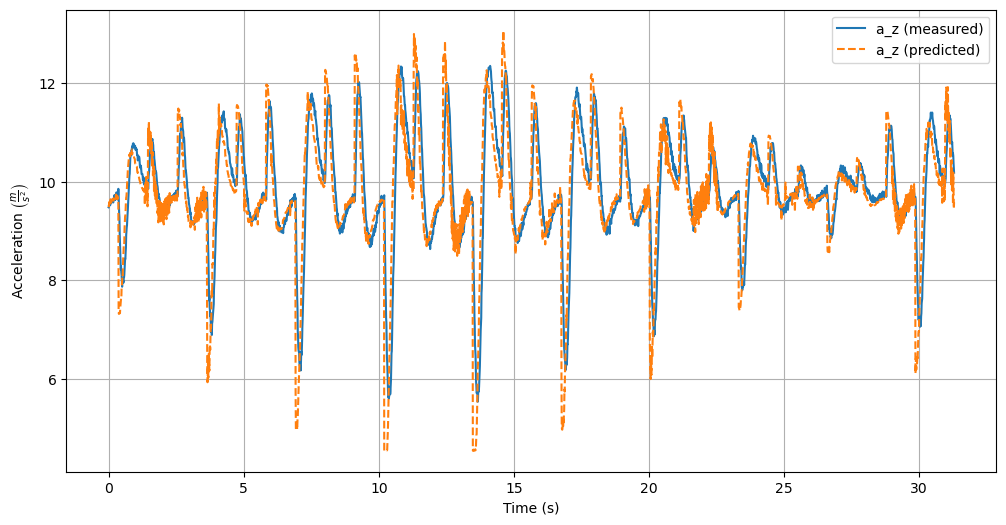

In [47]:
a_z_predicted = (1/m) * k_F * (m_1 + m_2 + m_3 + m_4)

plt.figure(figsize=(12, 6))
plt.plot(t, a_z, label='a_z (measured)')
plt.plot(t, a_z_predicted, '--', label='a_z (predicted)')
plt.grid()
plt.legend()
plt.ylabel(r"Acceleration $\left(\frac{m}{s^2}\right)$")
plt.xlabel('Time (s)')

# 5. Find the moment parameter

### 5.1 Moment Calibration Flight

In order to estimate the moment coefficient, the drone needs to fly near hover while varying the yaw moment from the rotors. While hovering, it can be assumed that the x and y components of anuglar velocity are close to zero. The approach taken in this experiment was to instruct the drone to turn back and forth while hovering at some fixed height. The following sequence of move commands was run in the client code to produce these results:

```python
height = 0.45
variation = 5

for i in range(0, 15) :
    # Turn left to a yaw angle of [variation] degrees:
    client.move(0.0, 0.0, height, variation, 0.5)
    # Turn right to a yaw angle of [variation] degrees:
    client.move(0.0, 0.0, height, -variation, 0.5)
    # Return to hover at a yaw angle of 0 degrees:
    client.move(0.0, 0.0, height, 0.0, 0.5)

    variation += 4
```
Here, height represents the target hover altitude, and variation represents the increasing deviation from a yaw of 0 degrees.

### 5.2 Get and plot flight data

Load and resample data.

In [48]:
data = load_hardware_data(
    'results/moment-data.json',
    t_min_offset=4.,
    t_max_offset=3.5,
)

Parse data to get:
* time
* the gyroscope measurements (**note!** these are in units of degrees / second)
* the motor power commands

In [49]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])
m_1 = data['motor.m1']
m_2 = data['motor.m2']
m_3 = data['motor.m3']
m_4 = data['motor.m4']

Find the time step. It should be `0.01` because data were sampled at 100 Hz.

In [50]:
dt = t[1] - t[0]
print(f'dt = {dt}')

dt = 0.01


Plot gyroscope measurements and motor power commands. Since the drone was near hover during flight (only yawing back and forth), the $x$ and $y$ gyroscope measurements should be much smaller than the $z$ gyroscope measurements.

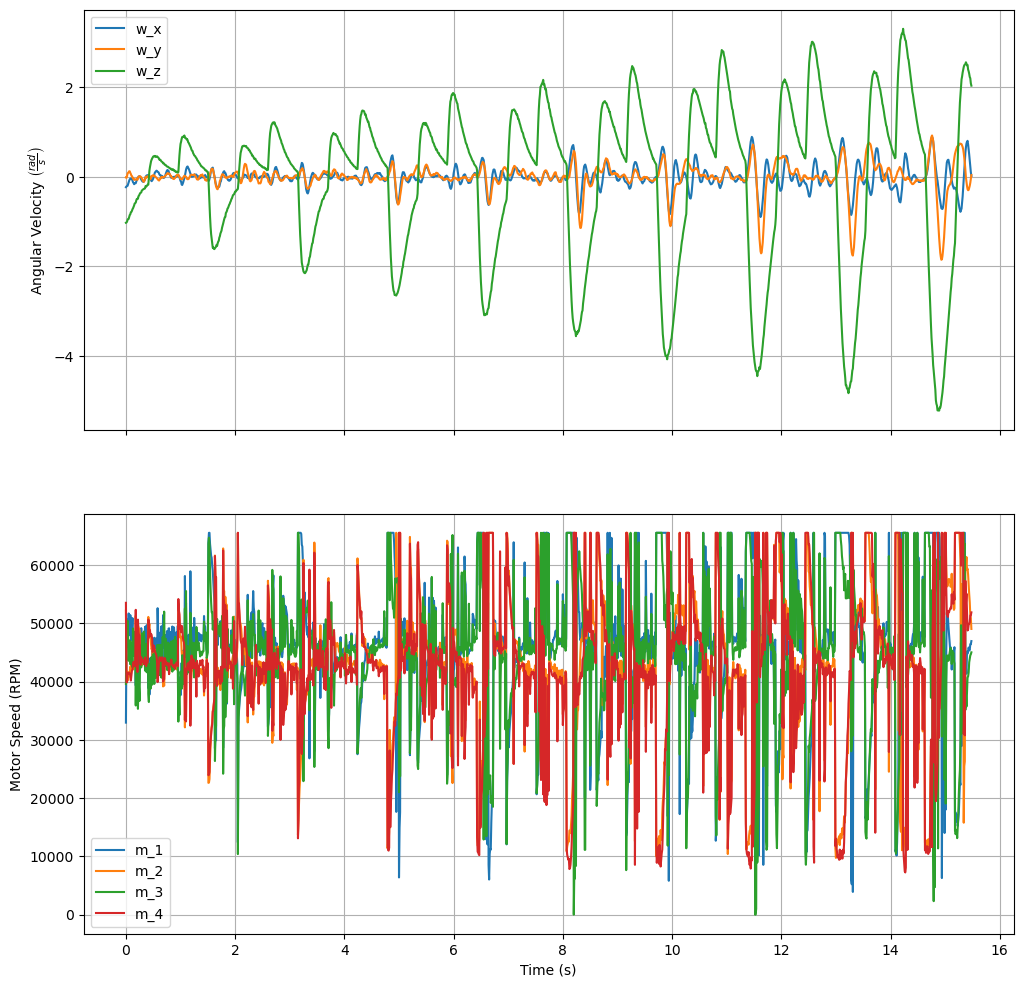

In [51]:
fig, (ax_w, ax_m) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax_w.plot(t, w_x, label='w_x')
ax_w.plot(t, w_y, label='w_y')
ax_w.plot(t, w_z, label='w_z')
ax_w.set_ylabel(r"Angular Velocity $\left(\frac{rad}{s}\right)$")
ax_w.legend()
ax_w.grid()
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.set_ylabel('Motor Speed (RPM)')
ax_m.set_xlabel('Time (s)')
ax_m.legend()
ax_m.grid()

### 5.3 Use finite difference to estimate $\dot{w}_z$

Estimate $\dot{w}_z$ by finite difference.

In [52]:
w_z_dot = np.zeros((len(w_z)-1))

for i in range(0, len(w_z)-1) :
    w1 = w_z[i]
    w2 = w_z[i+1]
    
    w_z_dot[i] = (w2 - w1) / (dt)
    
print(w_z_dot)

[  0.62035674   1.88014512   3.89749631 ...  -2.91706687 -11.33398749
  -5.25594815]


Plot both $w_z$ and $\dot{w}_z$.

Text(0.5, 0, 'Time (s)')

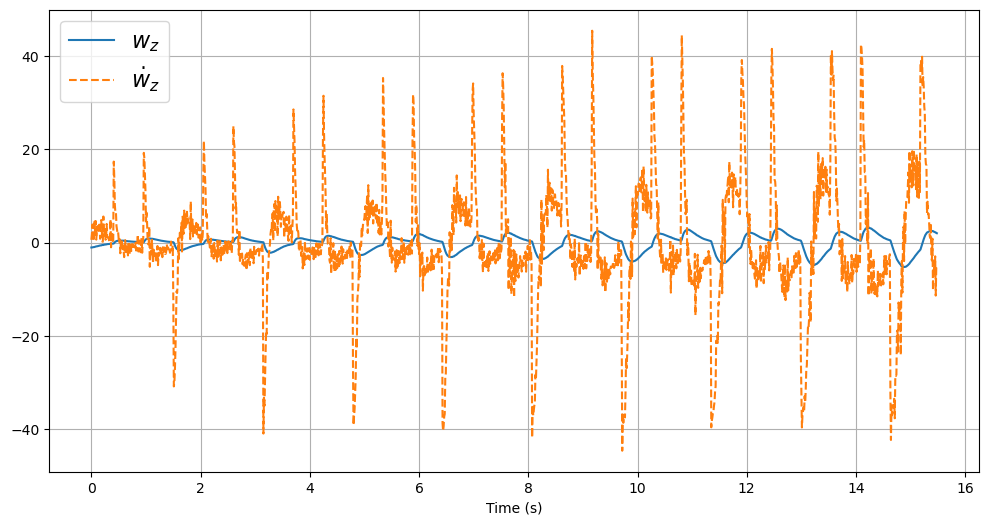

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(t, w_z, label='$w_z$')
plt.plot(t[:-1], w_z_dot, '--', label='$\dot{w}_z$')
plt.grid()
plt.legend(fontsize=16)
plt.xlabel("Time (s)")

### 5.4 Apply linear regression to estimate $k_M$

First, compute `x`.

In [54]:
x = -m_1 + m_2 - m_3 + m_4

Second, compute `y`.

In [55]:
y = J_z * w_z_dot

Third, compute `c_est`.

**If you do this without thinking, you will get an error!** In particular, you will likely see something like this:

```
ValueError: operands could not be broadcast together with shapes (1313,) (1314,)
```

The reason for this error is that you are trying to add, subtract, multiply, or divide (element-wise) two 1D numpy arrays that have different lengths. Remember, in particular, that `w_z_dot` has one fewer element than everything else. What will you need to change in order to make your code work without error?

In [56]:
c_est = np.sum(y * x[:-1]) / np.sum(np.square(x[:-1]))
print(c_est)

6.08127344058698e-09


Finally, compute `k_M` in terms of `c_est`.

In [57]:
k_M = c_est

Show the estimate.

In [58]:
print(f'k_M = {k_M:.4e}')

k_M = 6.0813e-09


### 5.5 Validate the estimate

Compare the linear fit to the raw data.

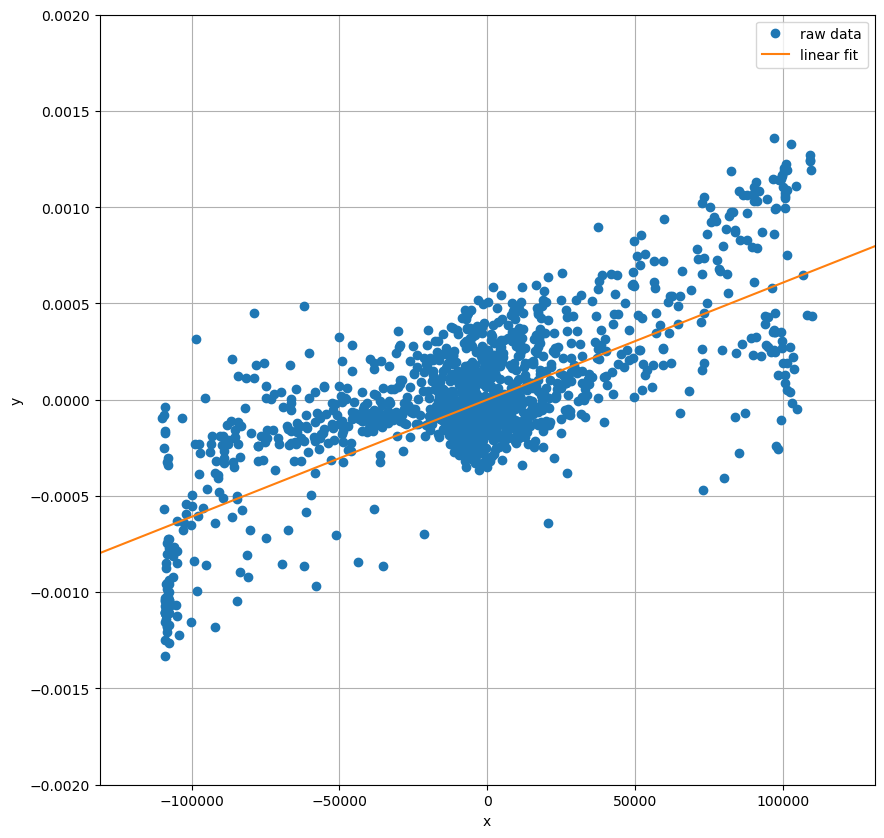

In [59]:
plt.figure(figsize=(10, 10))
plt.plot(x[:-1], y, '.', markersize=12, label='raw data')
plt.plot([-131070, 131070], [c_est * -131070, c_est * 131070], label='linear fit')
plt.xlim(-131070, 131070)
plt.xlabel('x')
plt.ylim(-.002, 0.002)
plt.ylabel('y')
plt.grid()
plt.legend()

Compare the finite-difference estimate of $\dot{w}_z$ to what you would have predicted using $k_M$.

Text(0, 0.5, 'Angular Acceleration $\\left(\\frac{rad}{s^2}\\right)$')

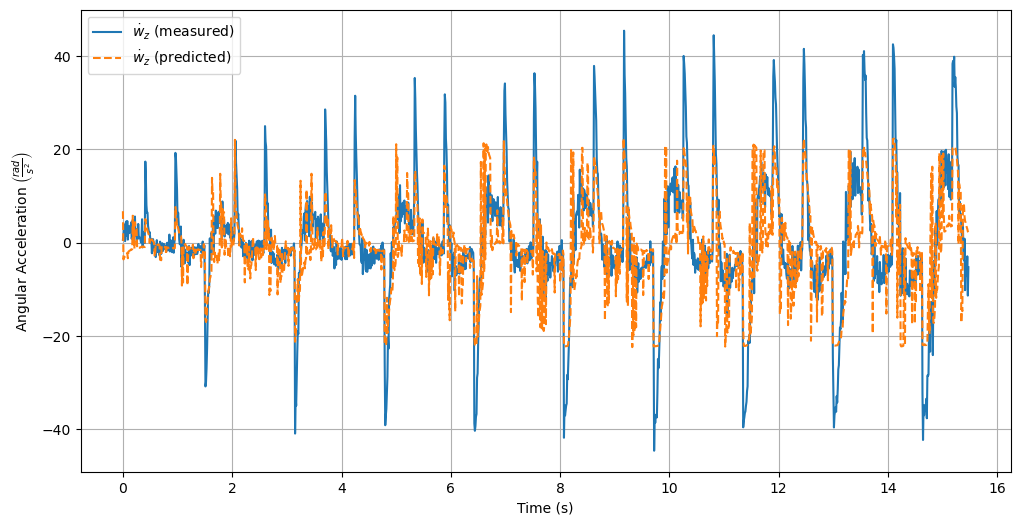

In [60]:
w_z_dot_predicted = k_M * (x[:-1]) / J_z

plt.figure(figsize=(12, 6))
plt.plot(t[:-1], w_z_dot, label='$\dot{w}_z$ (measured)')
plt.plot(t[:-1], w_z_dot_predicted, '--', label='$\dot{w}_z$ (predicted)')
plt.grid()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel(r"Angular Acceleration $\left(\frac{rad}{s^2}\right)$")

# 6. Derive equations of motion for the controller

## 6.1 Define symbolic variables

Define states.

In [61]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

Define inputs.

In [62]:
# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

Define parameters.

In [63]:
m, J_x, J_y, J_z, g = sym.symbols('m, J_x, J_y, J_z, g')

Create linear and angular velocity vectors (in coordinates of the body frame).

In [64]:
v_01in1 = sym.Matrix([v_x, v_y, v_z])
w_01in1 = sym.Matrix([w_x, w_y, w_z])

Create moment of inertia matrix (in coordinates of the body frame).

In [65]:
J_in1 = sym.diag(J_x, J_y, J_z)

## 6.2 Define kinematics of orientation

### 6.2.1 Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [66]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame 1 in the coordinates of frame 0).

In [67]:
R_1in0 = Rz * Ry * Rx

In [68]:
R_1in0

Matrix([
[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi),  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)],
[sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)],
[        -sin(theta),                              sin(phi)*cos(theta),                               cos(phi)*cos(theta)]])

### 6.2.2 Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [69]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([0, 0, 1]),
                              (Rx).T * sym.Matrix([0, 1, 0]),
                                       sym.Matrix([1, 0, 0]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [70]:
N = sym.simplify(Ninv.inv())

In [71]:
N

Matrix([
[0, sin(phi)/cos(theta), cos(phi)/cos(theta)],
[0,            cos(phi),           -sin(phi)],
[1, sin(phi)*tan(theta), cos(phi)*tan(theta)]])

## 6.3 Define equations of motion

Forces.

In [72]:
f_in1 = R_1in0.T * sym.Matrix([0, 0, -m * g]) + sym.Matrix([0, 0, f_z])

Torques.

In [73]:
tau_in1 = sym.Matrix([tau_x, tau_y, tau_z])

In [74]:
f_in1

Matrix([
[               g*m*sin(theta)],
[     -g*m*sin(phi)*cos(theta)],
[f_z - g*m*cos(phi)*cos(theta)]])

In [75]:
tau_in1

Matrix([
[tau_x],
[tau_y],
[tau_z]])

Create equations of motion.

In [76]:
f_sym = sym.Matrix.vstack(R_1in0 * v_01in1,
                          N * w_01in1,
                          (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1)),
                          J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1)))

Show equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

for states

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ w_x \\ w_y \\ w_z \end{bmatrix},
$$

inputs
$$
i = \begin{bmatrix} \tau_x \\ \tau_y \\ \tau_z \\ f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m \\ J_x \\ J_y \\ J_z \\ g \end{bmatrix}.
$$

In [77]:
f_sym

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                (g*m*sin(theta) + m*v_y*w_z - m*v_z*w_y)/m

# 7. Derive state-space model for the controller

## 7.1 Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ - along with constant parameters $p_\text{eq}$ - for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a list of states, inputs, and parameters as symbolic variables.

In [78]:
s = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
i = [tau_x, tau_y, tau_z, f_z]
p = [m, J_x, J_y, J_z, g]

Create a list of states to track as symbolic variables. These are states whose desired values will be specified by a client.

In [79]:
s_with_des = [o_x, o_y, o_z]

Create a function that evaluates $f(\cdot)$ at particular values of $s$, $i$, and $p$.

In [80]:
f = sym.lambdify(s + i + p, f_sym)

Define constants.

In [81]:
# Mass
m = 0.0359

# Principle moments of inertia
J_x = J_x_val
J_y = J_y_val
J_z = J_z_val

# Acceleration of gravity
g = 9.81

Create a list of parameter values in the **same order** as the symbolic list. These are the parameter estimates we found in our experiments. They are not choices. (We use the subscript `_eq` to be consistent with what follows, and could say "parameter values *at equilibrium*," but don't be misled. These parameter values are *given* and are *constant* - again, they aren't choices.)

In [82]:
p_eq = [m, J_x, J_y, J_z, g]

Create a list of state and input values at equilibrium in the **same order** as the symbolic lists.

In [83]:
s_eq = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] 
i_eq = [0., 0., 0., m*g]                                 

Evaluate the equations of motion at the equilibrium point - if it actually *is* an equilibrium point, then the result should be an array of zeros:

In [84]:
print(f(*s_eq, *i_eq, *p_eq))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Note that this equilibrium point would remain an equilibrium point for any choice of `o_x`, `o_y`, and `o_z` - that is one thing that allows the controller to track desired values of these variables.

## 7.2 Compute A and B

We want to find

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\text{and}\qquad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

First, we compute each Jacobian (i.e., each matrix of partial derivatives) in symbolic form.

In [85]:
A_sym = f_sym.jacobian(s)
B_sym = f_sym.jacobian(i)

Then, we create functions that allow us to evaluate these Jacobians at particular values of $s$, $i$, and $p$.

In [86]:
A_num = sym.lambdify(s + i + p, A_sym)
B_num = sym.lambdify(s + i + p, B_sym)

Finally, we plug in our equilibrium point.

In [87]:
A = A_num(*s_eq, *i_eq, *p_eq)
B = B_num(*s_eq, *i_eq, *p_eq)

Show $A$ (formatted nicely).

In [88]:
A_str = np.array2string(A,
                        formatter={'float_kind': lambda x: f'{x:5.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'A = {A_str}')

A = [[ 0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  1.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00]
     [ 0.00  0.00  0.00  0.00  0.00 -0.00  0.00  0.00  0.00  0.00  1.00 -0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  9.81  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00 -9.81 -0.00  0.00  0.00  0.00  0.00 -0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]]


Show $B$ (formatted nicely).

In [89]:
B_str = np.array2string(B,
                        formatter={'float_kind': lambda x: f'{x:10.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'B = {B_str}')

B = [[      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00      27.86]
     [  64982.18       0.00       0.00       0.00]
     [      0.00   68464.56       0.00       0.00]
     [      0.00       0.00   33483.20       0.00]]


The state-space system is described by

$$ \dot{x} = Ax + Bu $$

where

$$ x = s - s_\text{eq} $$

and

$$ u = i - i_\text{eq}. $$

Note that $A$ and $B$ would remain the same for any choice of `o_x`, `o_y`, and `o_z` - that is the other thing that allows the controller to track desired values of these variables.

# 8. Design method of power distribution

It should only be necessary to do this once.

Define constants.

In [90]:
l = 0.035

Define the matrix $P$ that maps motor power commands ($m_1$, $m_2$, $m_3$, $m_4$) to inputs ($\tau_x$, $\tau_y$, $\tau_z$, $f_z$).

In [91]:
P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Compute the matrix $P^{-1}$ that maps inputs to motor power commands.

In [92]:
Pinv = linalg.inv(P)

Print code that implements the method of power distribution in C (for hardware).

In [93]:
export_power_distribution(
    Pinv,
    limiter='limitUint16',
    suffix='f',
    line_ending=';',
)

m_1 = limitUint16( -3496531.0f * tau_x -3496531.0f * tau_y -41109810.7f * tau_z + 122378.6f * f_z );
m_2 = limitUint16( -3496531.0f * tau_x + 3496531.0f * tau_y + 41109810.7f * tau_z + 122378.6f * f_z );
m_3 = limitUint16( 3496531.0f * tau_x + 3496531.0f * tau_y -41109810.7f * tau_z + 122378.6f * f_z );
m_4 = limitUint16( 3496531.0f * tau_x -3496531.0f * tau_y + 41109810.7f * tau_z + 122378.6f * f_z );


# 9. Design, implement, and test a sequence of controllers

To get a working controller in hardware, you will likely need to repeat the following steps many times:

* Design a controller
* Implement and test this controller in simulation
* Implement and test this controller in hardware

Here is a template for these three steps. Please duplicate this template for each flight test. Please also modify this template as appropriate (e.g., doing more than one flight test with the same controller, or doing only hardware flight tests when fine-tuning performance after you get a working controller).

## 9.1 Flight test

Each time you duplicate this section, replace the title with a brief description of your current flight test.

### 9.1.1 Control design

For your controller, we suggest you use linear state feedback of the form

$$u = - K (x - x_\text{des})$$

where the gain matrix $K$ is chosen by solving an infinite-horizon LQR problem (e.g., with the helper function `lqr`) and where

$$x_\text{des} = \begin{bmatrix} o_{x, \text{des}} \\ o_{y, \text{des}} \\ o_{z, \text{des}} \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}.$$

Remember that the LQR problem is defined by the choice of weights $Q$ and $R$. Both must be square matrices, $Q$ must be positive semidefinite, and $R$ must be positive definite. Both $Q$ and $R$ are almost always chosen to be diagonal. Remember that $Q$ penalizes non-zero states (i.e., non-zero values of $x$) and that $R$ penalizes non-zero inputs (i.e., non-zero values of $u$). If you want smaller states, increase $Q$. If you want smaller inputs, increase $R$.

Here, $R$ was chosen after a number of iterative test flights that started with data from Labs 5 and 6.

In [94]:
Q = np.diag([
    1.5, #x
    1.4, #y
    2.0, #z
    1.28, #psi
    1.3, #theta
    0.4, #phi
    0.69, #vx
    0.8, #vy
    0.43,
    0.65,
    0.4,
    1.5,
])

R = np.diag([
    1e6,
    5e5,    
    5e5,
    5e2,
])

Find $K$ for the chosen $Q$ and $R$.

In [95]:
K = lqr(A, B, Q, R)

Show $K$ (formatted nicely).

In [96]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[-0.000 -0.001 -0.000 -0.000 -0.000  0.005 -0.000 -0.001 -0.000  0.001 -0.000 -0.000]
     [ 0.002  0.000  0.000  0.000  0.006 -0.000  0.002  0.000 -0.000 -0.000  0.001  0.000]
     [ 0.000 -0.000 -0.000  0.002  0.000  0.000  0.000 -0.000 -0.000 -0.000  0.000  0.002]
     [ 0.000  0.000  0.063  0.000 -0.000 -0.000 -0.000  0.000  0.073 -0.000 -0.000 -0.000]]


Print code that implements the controller in python (for simulation).

In [97]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
)

tau_x = 0.00118322 * (o_y - o_y_des) -0.00499485 * phi + 0.00141594 * v_y -0.00089651 * w_x
tau_y = -0.00173205 * (o_x - o_x_des) -0.00623766 * theta -0.00189279 * v_x -0.00099107 * w_y
tau_z = -0.00160000 * psi -0.00175942 * w_z
f_z = -0.06324555 * (o_z - o_z_des) -0.07349171 * v_z + 0.35217900


Print code that implements the controller in C (for hardware).

In [98]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)

tau_x = 0.00118322f * (o_y - o_y_des) -0.00499485f * phi + 0.00141594f * v_y -0.00089651f * w_x;
tau_y = -0.00173205f * (o_x - o_x_des) -0.00623766f * theta -0.00189279f * v_x -0.00099107f * w_y;
tau_z = -0.00160000f * psi -0.00175942f * w_z;
f_z = -0.06324555f * (o_z - o_z_des) -0.07349171f * v_z + 0.35217900f;


### 9.1.2 Hardware results

#### Plot results from the flight test

Load data from hardware.

In [99]:
data = load_hardware_data(
    'results/controller_flight_test.json', # <-- replace with name of file with hardware data
    t_min_offset=3.,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=2.,      # <-- (optional) replace with how many seconds of data to ignore at end
)

Parse data to get:

* time
* position
* desired position
* orientation
* motor power commands

In [100]:
# time
t = data['time']

# position
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# orientation
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']

# motor power commands
m_1 = data['ae483log.m_1']
m_2 = data['ae483log.m_2']
m_3 = data['ae483log.m_3']
m_4 = data['ae483log.m_4']

Compute error in position (this is a function of time).

In [101]:
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Plot position error, orientation, and motor power commands.

Text(0.5, 0, 'time (s)')

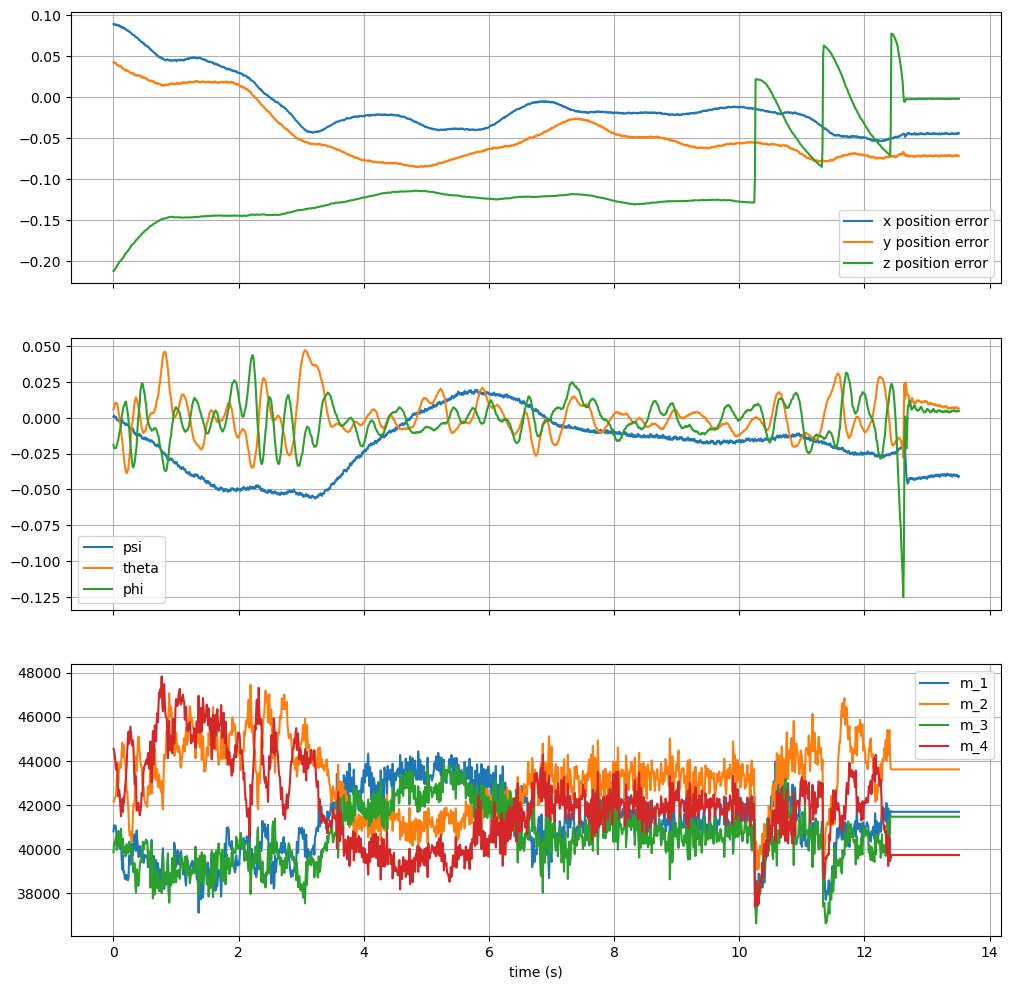

In [102]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')

In [103]:
o_x_rmse = np.sqrt(np.mean(o_x_err**2))
o_y_rmse = np.sqrt(np.mean(o_y_err**2))
o_z_rmse = np.sqrt(np.mean(o_z_err**2))
psi_rmse = np.sqrt(np.mean(psi**2))
theta_rmse = np.sqrt(np.mean(theta**2))
phi_rmse = np.sqrt(np.mean(phi**2))

print('RMSE in o_x', o_x_rmse)
print('RMSE in o_y', o_y_rmse)
print('RMSE in o_z', o_z_rmse)
print('RMSE in psi', psi_rmse)
print('RMSE in theta', theta_rmse)
print('RMSE in phi', phi_rmse)

RMSE in o_x 0.03505478303043832
RMSE in o_y 0.057552649485719115
RMSE in o_z 0.11773367844288163
RMSE in psi 0.02766424225227
RMSE in theta 0.01353093149794176
RMSE in phi 0.014375779318394392


# 10. Derive models for observer

## 10.1 Define symbolic variables

Define states.

In [104]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

Define inputs.

In [105]:
# gyroscope measurements - components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# z-axis accelerometer measurement - specific force (meters / second^2)
a_z = sym.symbols('a_z')

Define outputs.

In [106]:
x_meas, y_meas, z_meas = sym.symbols('x_meas, y_meas, z_meas')

Define parameters.

In [107]:
g, k_flow = sym.symbols('g, k_flow')

Create linear and angular velocity vectors (in coordinates of the body frame).

In [108]:
v_01in1 = sym.Matrix([[v_x], [v_y], [v_z]])
w_01in1 = sym.Matrix([[w_x], [w_y], [w_z]])

## 10.2 Define kinematics of orientation

### 10.2.1 Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [109]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame 1 in the coordinates of frame 0).

In [110]:
R_1in0 = Rz * Ry * Rx

### 10.2.2 Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [111]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([[0], [0], [1]]),
                              (Rx).T * sym.Matrix([[0], [1], [0]]),
                                       sym.Matrix([[1], [0], [0]]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [112]:
N = sym.simplify(Ninv.inv())

## 10.3 Derive equations of motion for observer

Ratio of net thrust to mass in terms of z-axis accelerometer measurement.

In [113]:
f_z_over_m = a_z + (w_01in1.cross(v_01in1))[2]

Ratio of forces to mass.

In [114]:
f_in1_over_m = R_1in0.T * sym.Matrix([[0], [0], [-g]]) + sym.Matrix([[0], [0], [f_z_over_m]])

Equations of motion.

In [115]:
f = sym.Matrix.vstack(
    R_1in0 * v_01in1,
    N * w_01in1,
    (f_in1_over_m - w_01in1.cross(v_01in1)),
)

Show equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

where

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \end{bmatrix}.
$$

In [116]:
f

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                          g*sin(theta) + v_y*w_z - v_z*w_y

## 10.4 Derive measurement equations

Create measurement equations.

In [117]:
h = sym.Matrix([
    o_x,        # <-- lighthouse x position (x_meas)
    o_y,        # <-- lighthouse y position (y_meas)
    o_z,   # <-- lighthouse z position (z_meas)
])

Show measurement equations, which have the form

$$o = h(s, i, p)$$

where

$$
o = \begin{bmatrix} x_{meas} \\ y_{meas} \\ z_{meas} \end{bmatrix}
\qquad\qquad
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \end{bmatrix}.
$$

In [118]:
h

Matrix([
[o_x],
[o_y],
[o_z]])

# 11. Derive state-space model for the observer

## 11.1 Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ - along with constant parameters $p_\text{eq}$ - for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a symbolic variable to describe the equilibrium value of $o_z$.

In [119]:
o_z_eq = sym.symbols('o_z_eq')

Create a list of states, inputs, outputs, and parameters as symbolic variables.

In [120]:
s = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z]
i = [w_x, w_y, w_z, a_z]
o = [x_meas, y_meas, z_meas]
p = [g, k_flow]

Create a list of state and input values at equilibrium in the **same order** as before.

In [121]:
s_eq = [0, 0, o_z_eq, 0, 0, 0, 0, 0, 0]
i_eq = [0, 0, 0, g]

Make sure all equilibrium values are symbolic.

In [122]:
s_eq = [sym.nsimplify(a) for a in s_eq]
i_eq = [sym.nsimplify(a) for a in i_eq]

Evaluate the equations of motion at the equilibrium point - if it actually *is* an equilibrium point, then the result should be a matrix of zeros:

In [123]:
f.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

## 11.2 Find $A$, $B$, $C$, and $D$ for the observer

Recall that:

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
C = \frac{\partial h}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
D = \frac{\partial h}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

Compute each Jacobian and plug in the equilibrium values as follows.

In [124]:
A = f.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
B = f.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
C = h.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
D = h.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Show $A$:

In [125]:
A

Matrix([
[0, 0, 0, 0, 0,  0, 1, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 1, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 1],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, g,  0, 0, 0, 0],
[0, 0, 0, 0, 0, -g, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0]])

In [126]:
A_val = np.array(A.subs(g, 9.81)).astype(np.float64)

Show $B$:

In [127]:
B

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[1, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 1]])

In [128]:
B_val = np.array(B.subs(g, 9.81)).astype(np.float64)

Show $C$:

In [129]:
C

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [130]:
C_val = np.array(C.subs(g, 9.81)).astype(np.float64)

Show $D$ (note that it is *not* zero in this case):

In [131]:
D

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [132]:
D_val = np.array(D.subs(g, 9.81)).astype(np.float64)

## 11.3 Write linearized models

Define the state, input, and output of the state-space system (i.e., the linearized model of the equations of motion and of the measurement equations).

In [133]:
x = sym.Matrix(s) - sym.Matrix(s_eq)
u = sym.Matrix(i) - sym.Matrix(i_eq)
y = sym.Matrix(o) - h.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Show the linearized equations of motion $Ax+Bu$.

In [134]:
A * x + B * u

Matrix([
[    v_x],
[    v_y],
[    v_z],
[    w_z],
[    w_y],
[    w_x],
[g*theta],
[ -g*phi],
[a_z - g]])

Show the linearized measurement equations $Cx+Du$.

In [135]:
C * x + D * u

Matrix([
[         o_x],
[         o_y],
[o_z - o_z_eq]])

Show the output (which our model tells us should be $Cx+Du$).

In [136]:
y

Matrix([
[          x_meas],
[          y_meas],
[-o_z_eq + z_meas]])

# 12. Study error in linearized models

## 12.1 Load and parse flight data

Load flight data.

In [137]:
data = load_hardware_data(
    'results/custom_flight.json',  # <-- replace with name of file with hardware data
    t_min_offset=0.,       # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=0.,       # <-- (optional) replace with how many seconds of data to ignore at end
    only_in_flight=True,   # <-- (optional) only loads data for which o_z_des is positive
)

Parse flight data.

In [138]:
# time
t = data['time']

# states
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']
v_x = data['ae483log.v_x']
v_y = data['ae483log.v_y']
v_z = data['ae483log.v_z']

# inputs
w_x = data['ae483log.w_x']
w_y = data['ae483log.w_y']
w_z = data['ae483log.w_z']
a_z = data['ae483log.a_z']

# outputs

x_meas = data['ae483log.x_meas']
y_meas = data['ae483log.y_meas']
z_meas = data['ae483log.z_meas']

Find time step (should be 0.01).

In [139]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')

dt = 0.0100


Define numerical values of each parameter.

In [140]:
# Gravity
g = 9.81

# Equilibrium value of o_z
o_z_eq = 0.5

## 12.2 Error in linearized equations of motion

### 12.2.1 Error in linear model of $\dot{o}_x$

Approximate $\dot{o}_x$ by finite difference and call this "ground truth."

In [141]:
o_x_dot_true = (o_x[1:] - o_x[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_x_dot_true` is one less than the length of `o_x` (and of `t`):

In [142]:
print(f'len(o_x_dot_true) = {len(o_x_dot_true)}')
print(f'         len(o_x) = {len(o_x)}')
print(f'           len(t) = {len(t)}')

len(o_x_dot_true) = 3475
         len(o_x) = 3476
           len(t) = 3476


Predict $\dot{o}_x$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_x$, and that the first element of $Ax+Bu$ is $v_x$. So, our state-space model tells us that $\dot{o}_x \approx v_x$.

In [143]:
o_x_dot_predicted = v_x

Compare the true value and the predicted values of $\dot{o}_x$ in a plot.

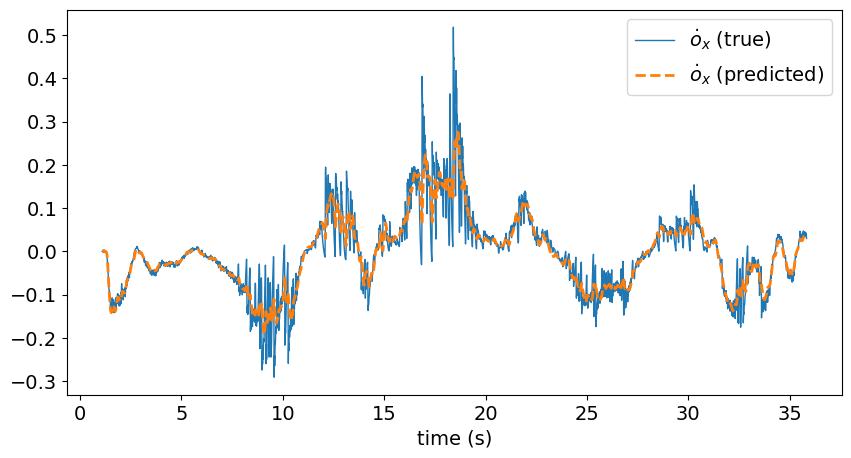

In [144]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_x_dot_true, label='$\dot{o}_x$ (true)', linewidth=1)
plt.plot(t, o_x_dot_predicted, '--', label='$\dot{o}_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_x$.

In [145]:
o_x_dot_err = o_x_dot_predicted[:-1] - o_x_dot_true

Plot a histogram of the error, showing mean and standard deviation.

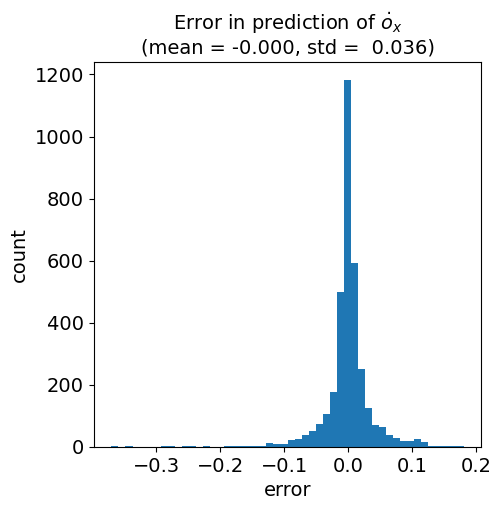

In [146]:
plt.figure(figsize=(5, 5))
plt.hist(o_x_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{o}_x$\n' +
    f'(mean = {np.mean(o_x_dot_err):6.3f}, std = {np.std(o_x_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.2.2 Error in linear model of $\dot{o}_y$

Approximate $\dot{o}_y$ by finite difference and call this "ground truth."

In [147]:
o_y_dot_true = (o_y[1:] - o_y[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_y_dot_true` is one less than the length of `o_y` (and of `t`):

In [148]:
print(f'len(o_y_dot_true) = {len(o_y_dot_true)}')
print(f'         len(o_y) = {len(o_y)}')
print(f'           len(t) = {len(t)}')

len(o_y_dot_true) = 3475
         len(o_y) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [149]:
o_y_dot_predicted = v_y

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

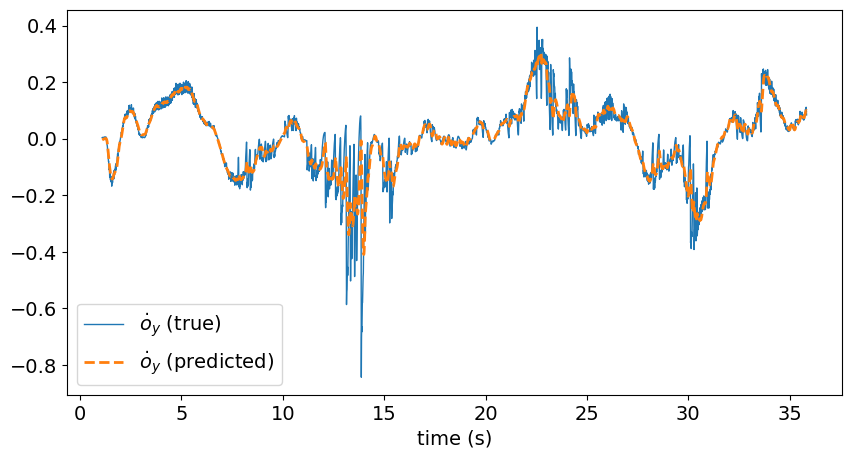

In [150]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_y_dot_true, label='$\dot{o}_y$ (true)', linewidth=1)
plt.plot(t, o_y_dot_predicted, '--', label='$\dot{o}_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [151]:
o_y_dot_err = o_y_dot_predicted[:-1] - o_y_dot_true

Plot a histogram of the error, showing mean and standard deviation.

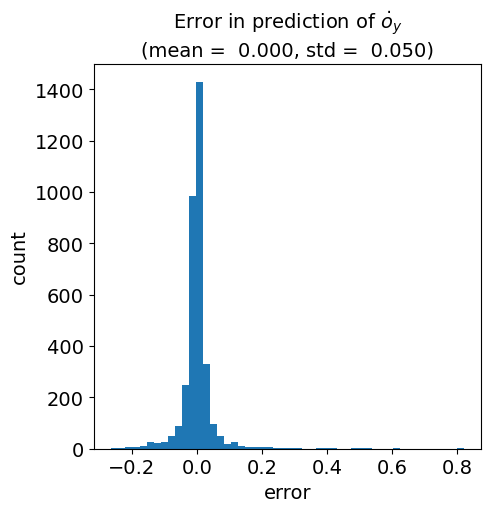

In [152]:
plt.figure(figsize=(5, 5))
plt.hist(o_y_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{o}_y$\n' +
    f'(mean = {np.mean(o_y_dot_err):6.3f}, std = {np.std(o_y_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.2.3 Error in linear model of $\dot{o}_z$

Approximate $\dot{o}_z$ by finite difference and call this "ground truth."

In [153]:
o_z_dot_true = (o_z[1:] - o_z[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_z_dot_true` is one less than the length of `o_z` (and of `t`):

In [154]:
print(f'len(o_z_dot_true) = {len(o_z_dot_true)}')
print(f'         len(o_z) = {len(o_z)}')
print(f'           len(t) = {len(t)}')

len(o_z_dot_true) = 3475
         len(o_z) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [155]:
o_z_dot_predicted = v_z

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

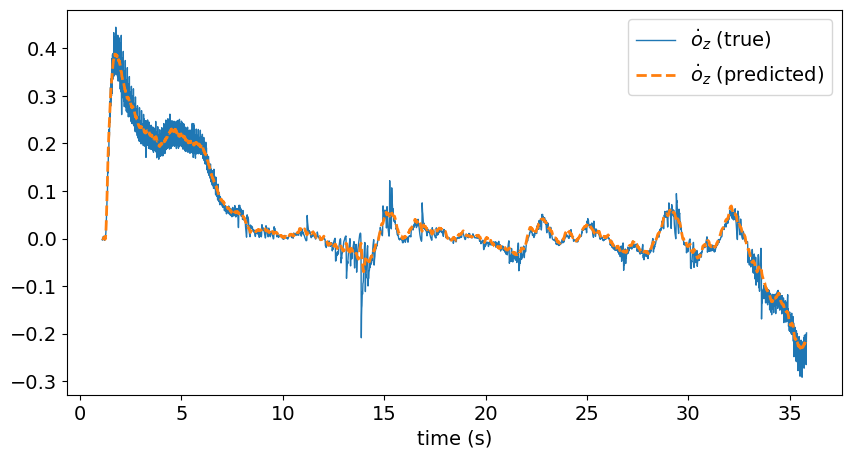

In [156]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_z_dot_true, label='$\dot{o}_z$ (true)', linewidth=1)
plt.plot(t, o_z_dot_predicted, '--', label='$\dot{o}_z$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [157]:
o_z_dot_err = o_z_dot_predicted[:-1] - o_z_dot_true

Plot a histogram of the error, showing mean and standard deviation.

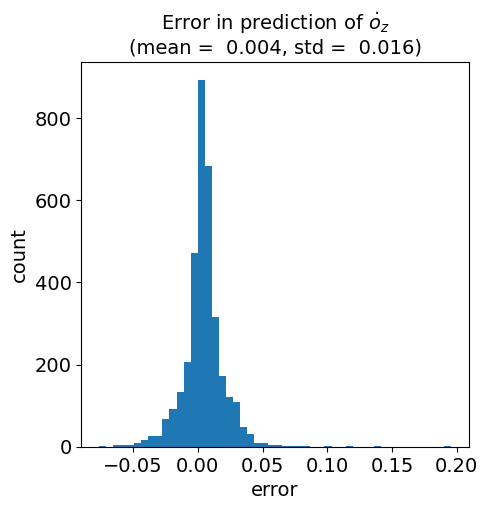

In [158]:
plt.figure(figsize=(5, 5))
plt.hist(o_z_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{o}_z$\n' +
    f'(mean = {np.mean(o_z_dot_err):6.3f}, std = {np.std(o_z_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.2.4 Error in linear model of $\dot{\psi}$

Approximate $\dot{o}_y$ by finite difference and call this "ground truth."

In [159]:
psi_dot_true = (psi[1:] - psi[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_y_dot_true` is one less than the length of `o_y` (and of `t`):

In [160]:
print(f'len(psi_dot_true) = {len(psi_dot_true)}')
print(f'         len(psi) = {len(psi)}')
print(f'           len(t) = {len(t)}')

len(psi_dot_true) = 3475
         len(psi) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [161]:
psi_dot_predicted = w_z

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

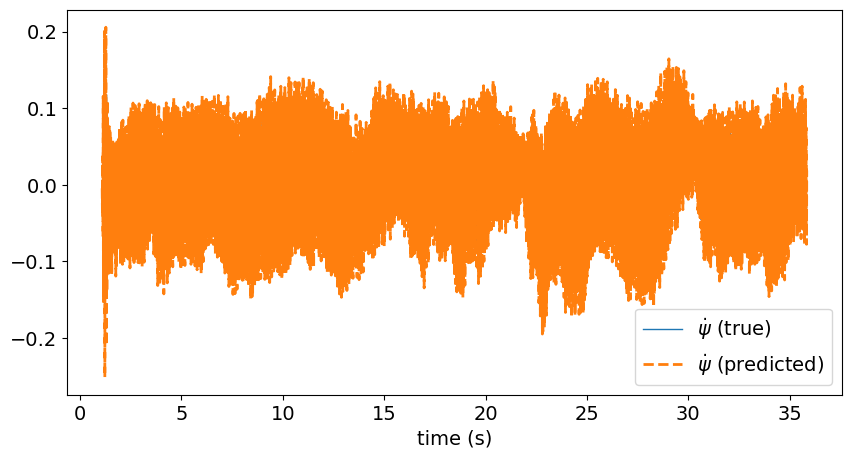

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], psi_dot_true, label='$\dot{\psi}$ (true)', linewidth=1)
plt.plot(t, psi_dot_predicted, '--', label='$\dot{\psi}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [163]:
psi_dot_err = psi_dot_predicted[:-1] - psi_dot_true

Plot a histogram of the error, showing mean and standard deviation.

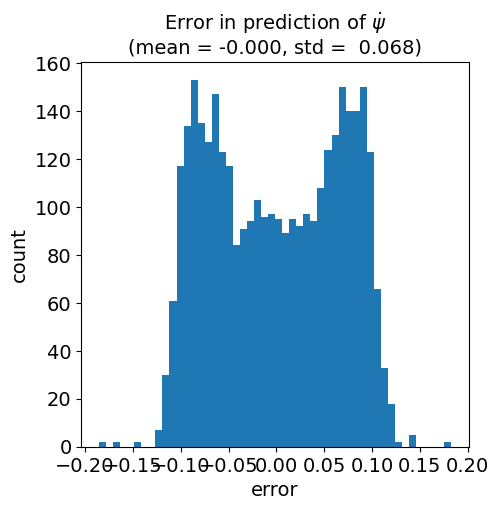

In [164]:
plt.figure(figsize=(5, 5))
plt.hist(psi_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{\psi}$\n' +
    f'(mean = {np.mean(psi_dot_err):6.3f}, std = {np.std(psi_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.2.5 Error in linear model of $\dot{\theta}$

Approximate $\dot{o}_y$ by finite difference and call this "ground truth."

In [165]:
theta_dot_true = (theta[1:] - theta[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_y_dot_true` is one less than the length of `o_y` (and of `t`):

In [166]:
print(f'len(theta_dot_true) = {len(theta_dot_true)}')
print(f'         len(theta) = {len(theta)}')
print(f'           len(t) = {len(t)}')

len(theta_dot_true) = 3475
         len(theta) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [167]:
theta_dot_predicted = w_y

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

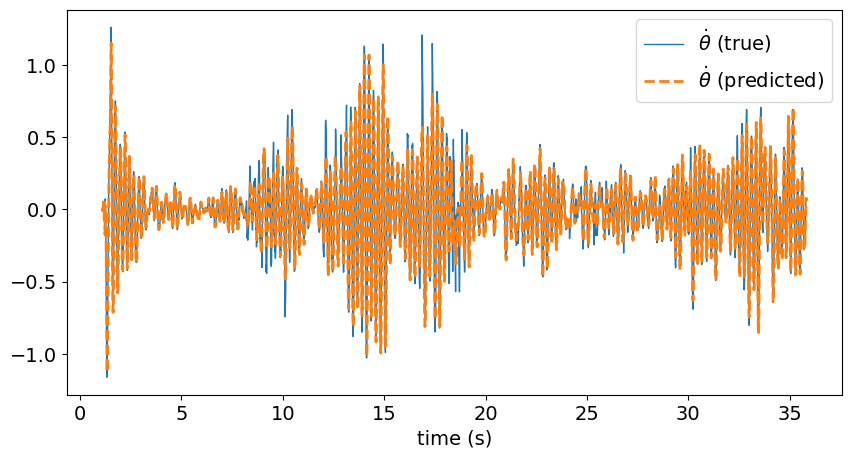

In [168]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], theta_dot_true, label=r"$\dot{\theta}$ (true)", linewidth=1)
plt.plot(t, theta_dot_predicted, '--', label=r"$\dot{\theta}$ (predicted)", linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [169]:
theta_dot_err = theta_dot_predicted[:-1] - theta_dot_true

Plot a histogram of the error, showing mean and standard deviation.

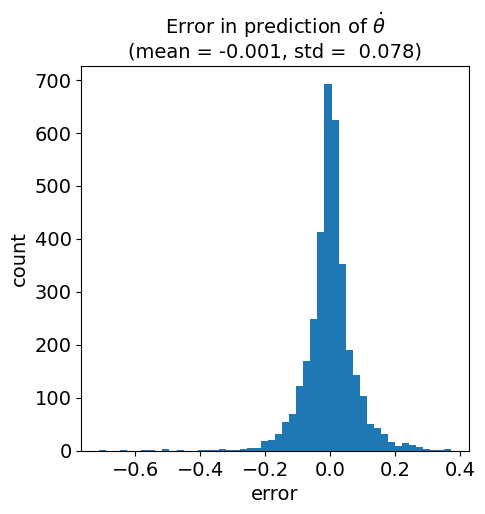

In [170]:
plt.figure(figsize=(5, 5))
plt.hist(theta_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    r"Error in prediction of $\dot{\theta}$" + '\n' + 
    f'(mean = {np.mean(theta_dot_err):6.3f}, std = {np.std(theta_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.2.6 Error in linear model of $\dot{\phi}$

Approximate $\dot{o}_y$ by finite difference and call this "ground truth."

In [171]:
phi_dot_true = (phi[1:] - phi[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_y_dot_true` is one less than the length of `o_y` (and of `t`):

In [172]:
print(f'len(phi_dot_true) = {len(phi_dot_true)}')
print(f'         len(phi) = {len(phi)}')
print(f'           len(t) = {len(t)}')

len(phi_dot_true) = 3475
         len(phi) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [173]:
phi_dot_predicted = w_x

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

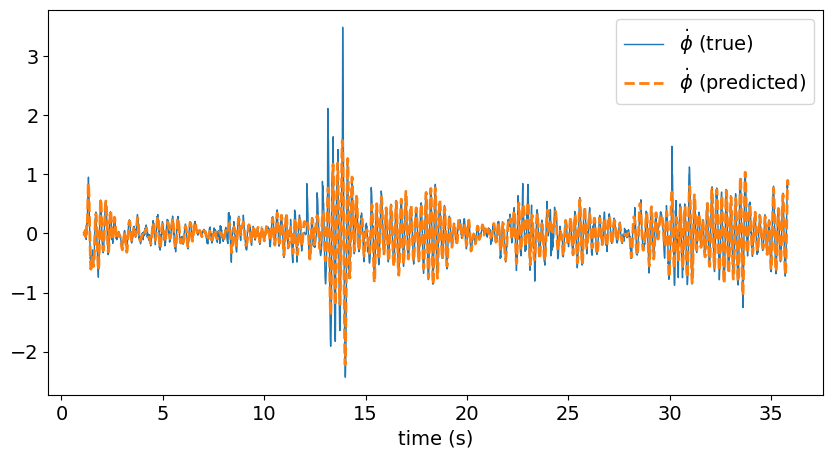

In [174]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], phi_dot_true, label=r"$\dot{\phi}$ (true)", linewidth=1)
plt.plot(t, phi_dot_predicted, '--', label=r"$\dot{\phi}$ (predicted)", linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [175]:
phi_dot_err = phi_dot_predicted[:-1] - phi_dot_true

Plot a histogram of the error, showing mean and standard deviation.

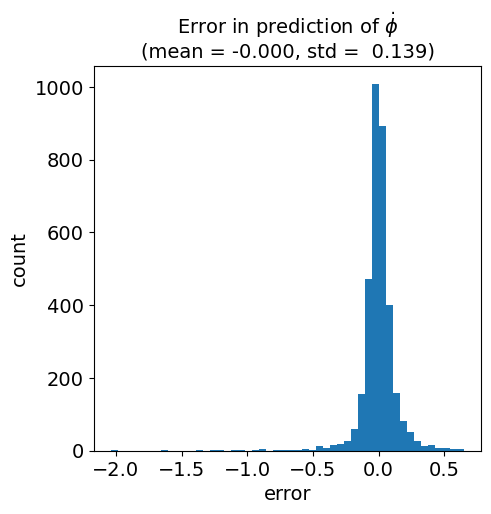

In [176]:
plt.figure(figsize=(5, 5))
plt.hist(phi_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    r"Error in prediction of $\dot{\phi}$" + '\n' + 
    f'(mean = {np.mean(phi_dot_err):6.3f}, std = {np.std(phi_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.2.7 Error in linear model of $\dot{v}_x$

Approximate $\dot{o}_z$ by finite difference and call this "ground truth."

In [177]:
v_x_dot_true = (v_x[1:] - v_x[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_z_dot_true` is one less than the length of `o_z` (and of `t`):

In [178]:
print(f'len(v_x_dot_true) = {len(v_x_dot_true)}')
print(f'         len(v_x) = {len(v_x)}')
print(f'           len(t) = {len(t)}')

len(v_x_dot_true) = 3475
         len(v_x) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [179]:
v_x_dot_predicted = g * theta

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

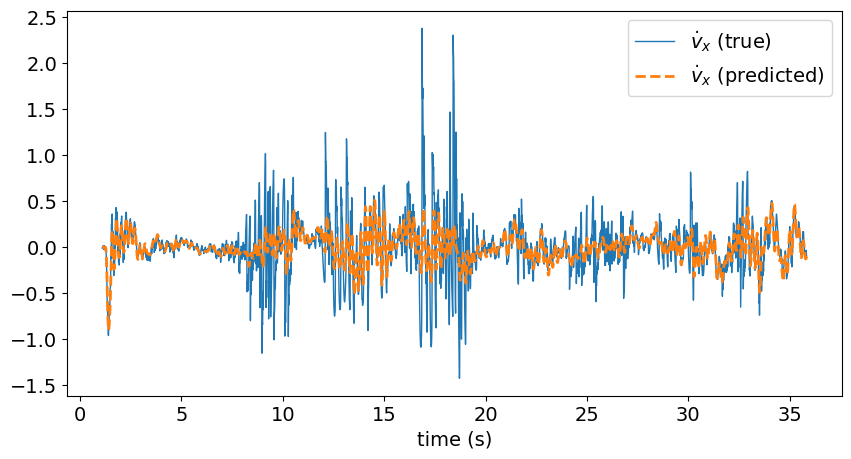

In [180]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_x_dot_true, label='$\dot{v}_x$ (true)', linewidth=1)
plt.plot(t, v_x_dot_predicted, '--', label='$\dot{v}_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [181]:
v_x_dot_err = v_x_dot_predicted[:-1] - v_x_dot_true

Plot a histogram of the error, showing mean and standard deviation.

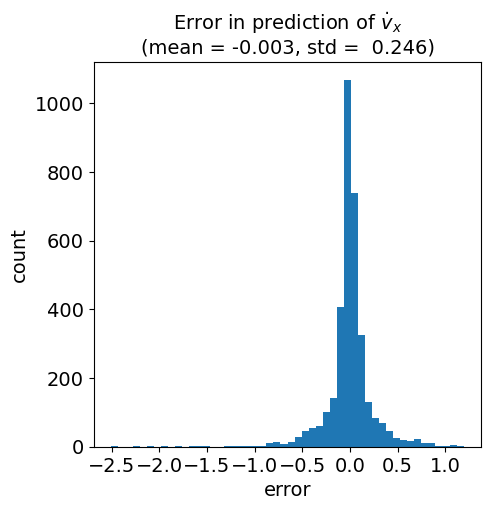

In [182]:
plt.figure(figsize=(5, 5))
plt.hist(v_x_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{v}_x$\n' +
    f'(mean = {np.mean(v_x_dot_err):6.3f}, std = {np.std(v_x_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.2.8 Error in linear model of $\dot{v}_y$

Approximate $\dot{o}_z$ by finite difference and call this "ground truth."

In [183]:
v_y_dot_true = (v_y[1:] - v_y[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_z_dot_true` is one less than the length of `o_z` (and of `t`):

In [184]:
print(f'len(v_y_dot_true) = {len(v_y_dot_true)}')
print(f'         len(v_y) = {len(v_y)}')
print(f'           len(t) = {len(t)}')

len(v_y_dot_true) = 3475
         len(v_y) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [185]:
v_y_dot_predicted = -g * phi

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

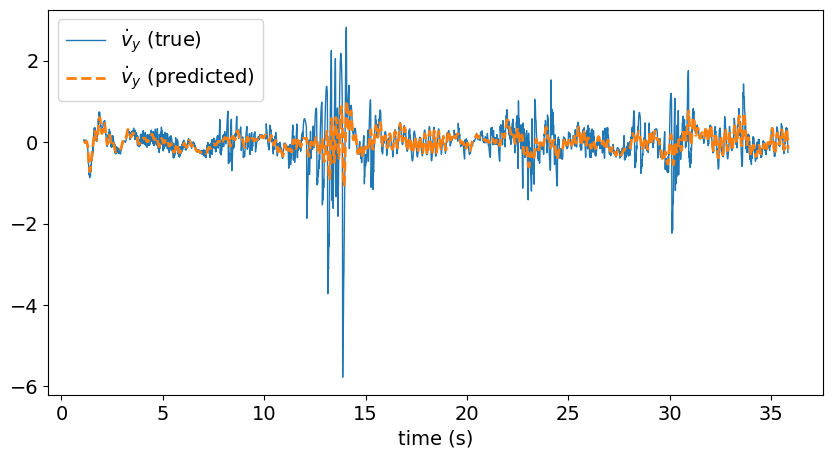

In [186]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_y_dot_true, label='$\dot{v}_y$ (true)', linewidth=1)
plt.plot(t, v_y_dot_predicted, '--', label='$\dot{v}_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [187]:
v_y_dot_err = v_y_dot_predicted[:-1] - v_y_dot_true

Plot a histogram of the error, showing mean and standard deviation.

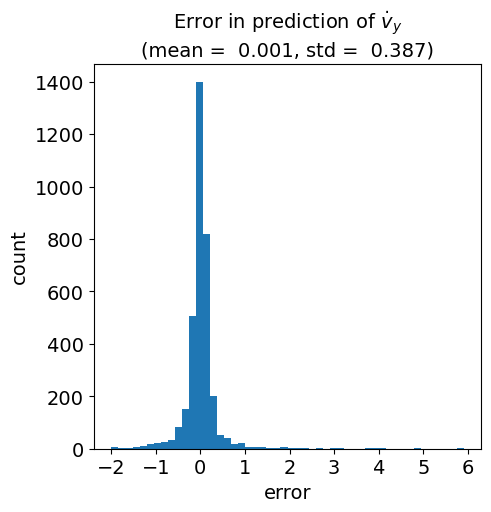

In [188]:
plt.figure(figsize=(5, 5))
plt.hist(v_y_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{v}_y$\n' +
    f'(mean = {np.mean(v_y_dot_err):6.3f}, std = {np.std(v_y_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.2.9 Error in linear model of $\dot{v}_z$

Approximate $\dot{o}_z$ by finite difference and call this "ground truth."

In [189]:
v_z_dot_true = (v_z[1:] - v_z[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_z_dot_true` is one less than the length of `o_z` (and of `t`):

In [190]:
print(f'len(v_z_dot_true) = {len(v_z_dot_true)}')
print(f'         len(v_z) = {len(v_z)}')
print(f'           len(t) = {len(t)}')

len(v_z_dot_true) = 3475
         len(v_z) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [191]:
v_z_dot_predicted = a_z - g

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

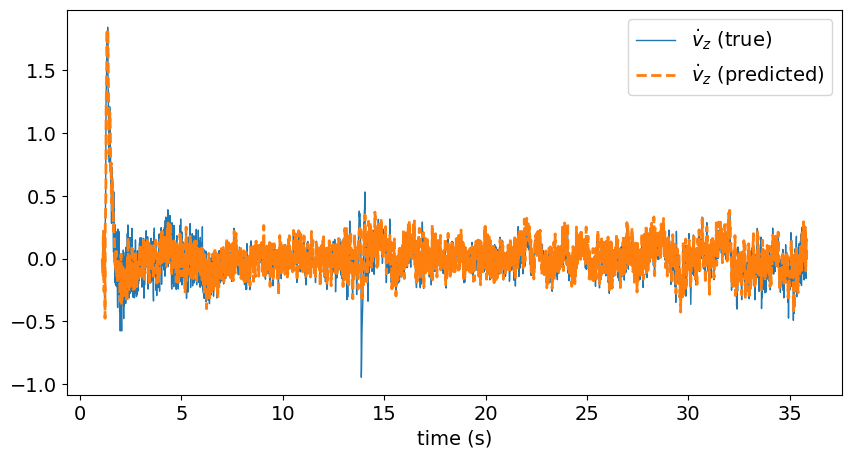

In [192]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_z_dot_true, label='$\dot{v}_z$ (true)', linewidth=1)
plt.plot(t, v_z_dot_predicted, '--', label='$\dot{v}_z$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [193]:
v_z_dot_err = v_z_dot_predicted[:-1] - v_z_dot_true

Plot a histogram of the error, showing mean and standard deviation.

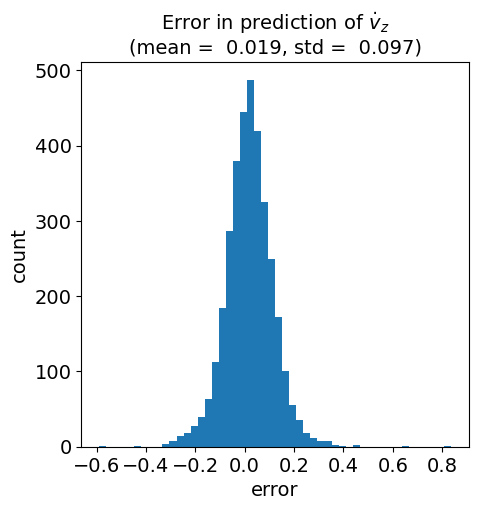

In [194]:
plt.figure(figsize=(5, 5))
plt.hist(v_z_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{v}_z$\n' +
    f'(mean = {np.mean(v_z_dot_err):6.3f}, std = {np.std(v_z_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

## 12.3 Error in linearized measurement equations

### 12.3.1 Error in linear model of $x_{meas}$

Predict $x_{meas}$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $x_{meas}$, and that the first element of $Cx+Du$ is

$$o_x,$$

so our linear model tells us that

$$x_{meas} \approx o_x.$$

In [195]:
x_meas_predicted = o_x

Compare the true value and the predicted values of $n_x$ in a plot.

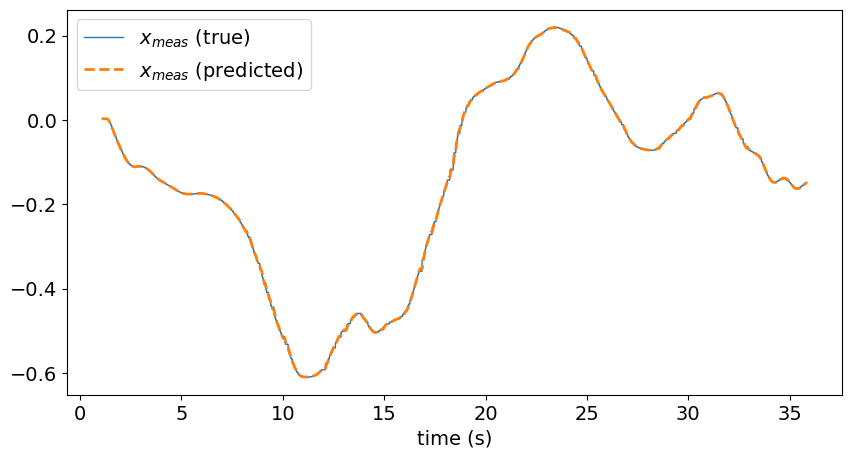

In [196]:
plt.figure(figsize=(10, 5))
plt.plot(t, x_meas, label='$x_{meas}$ (true)', linewidth=1)
plt.plot(t, x_meas_predicted, '--', label='$x_{meas}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [197]:
x_meas_err = x_meas_predicted - x_meas

Plot a histogram of the error, showing mean and standard deviation.

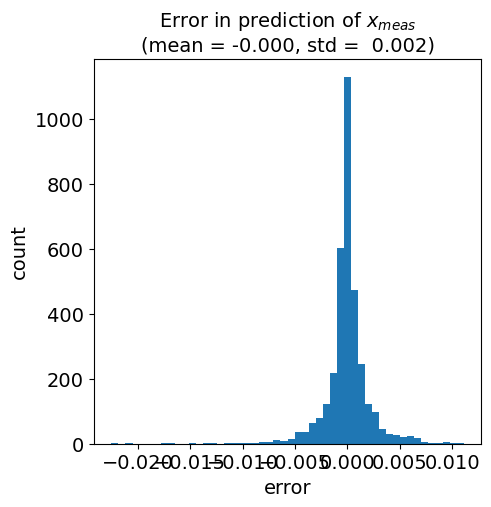

In [198]:
plt.figure(figsize=(5, 5))
plt.hist(x_meas_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $x_{meas}$\n' +
    f'(mean = {np.mean(x_meas_err):6.3f}, std = {np.std(x_meas_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.3.2 Error in linear model of $y_{meas}$

Predict $y_{meas}$ with the linearized measurement equations.

In particular, note that the second element of $y$ is $y_{meas}$, and that the second element of $Cx+Du$ is

$$o_y,$$

so our linear model tells us that

$$y_{meas} \approx o_y.$$

In [199]:
y_meas_predicted = o_y

Compare the true value and the predicted values of $n_x$ in a plot.

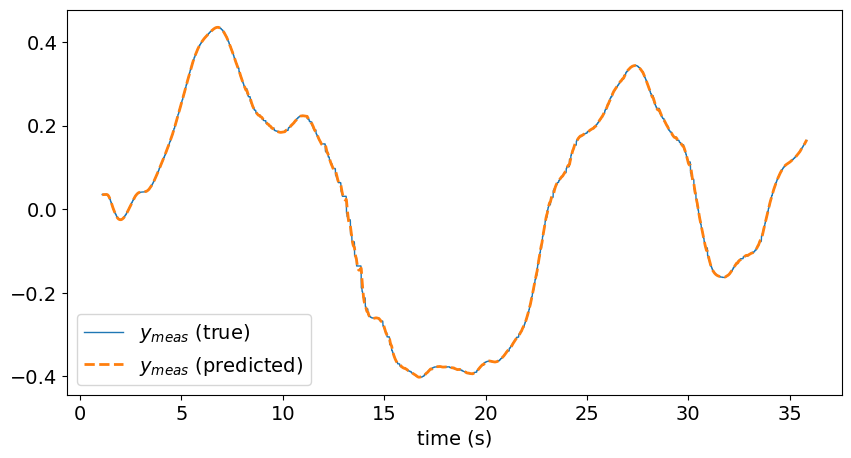

In [200]:
plt.figure(figsize=(10, 5))
plt.plot(t, y_meas, label='$y_{meas}$ (true)', linewidth=1)
plt.plot(t, y_meas_predicted, '--', label='$y_{meas}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [201]:
y_meas_err = y_meas_predicted - y_meas

Plot a histogram of the error, showing mean and standard deviation.

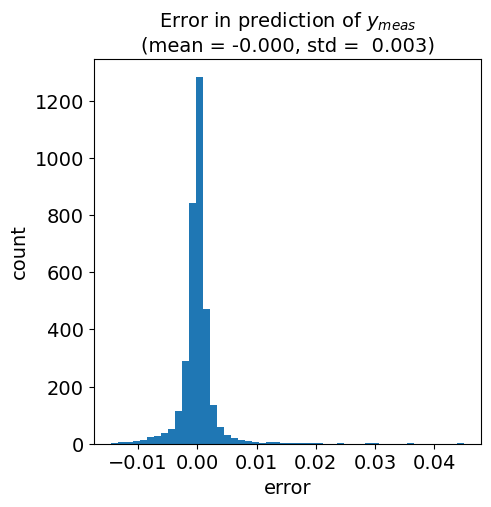

In [202]:
plt.figure(figsize=(5, 5))
plt.hist(y_meas_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $y_{meas}$\n' +
    f'(mean = {np.mean(y_meas_err):6.3f}, std = {np.std(y_meas_err):6.3f})',
    fontsize=14,
)
plt.show()

### 12.3.3 Error in linear model of $z_{meas}$

Predict $z_{meas}$ with the linearized measurement equations.

In particular, note that the second element of $y$ is $z_{meas}$, and that the second element of $Cx+Du$ is

$$o_z,$$

so our linear model tells us that

$$z_{meas} \approx o_z.$$

In [203]:
z_meas_predicted = o_z

Compare the true value and the predicted values of $z_{meas}$ in a plot.

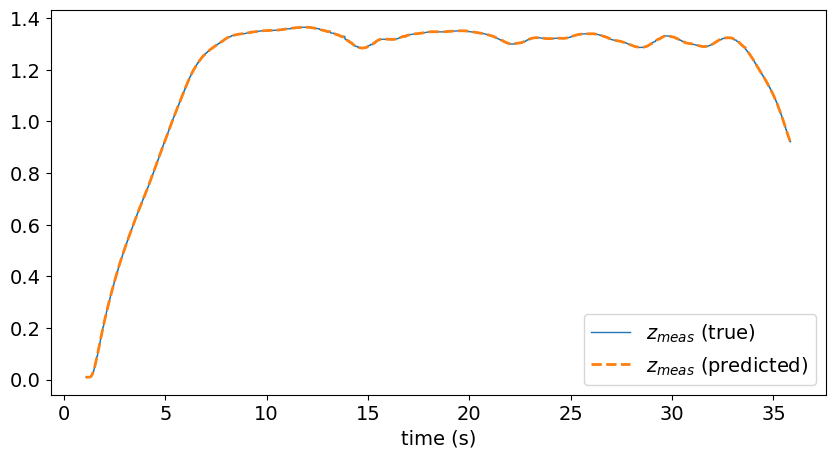

In [204]:
plt.figure(figsize=(10, 5))
plt.plot(t, z_meas, label='$z_{meas}$ (true)', linewidth=1)
plt.plot(t, z_meas_predicted, '--', label='$z_{meas}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $z_{meas}$.

In [205]:
z_meas_err = z_meas_predicted - z_meas

Plot a histogram of the error, showing mean and standard deviation.

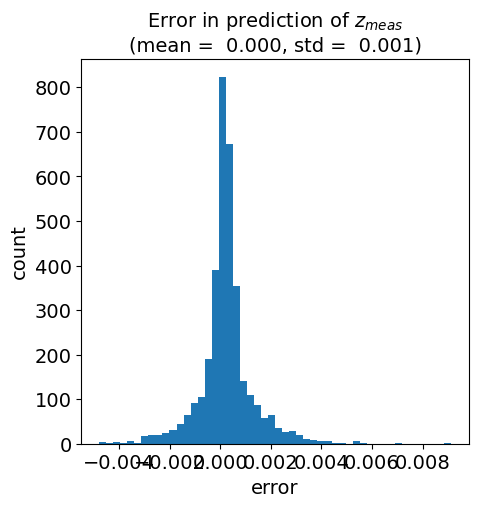

In [206]:
plt.figure(figsize=(5, 5))
plt.hist(z_meas_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $z_{meas}$\n' +
    f'(mean = {np.mean(z_meas_err):6.3f}, std = {np.std(z_meas_err):6.3f})',
    fontsize=14,
)
plt.show()

## 12.4 Summary

The following table reports the mean and standard deviation of error in the linearized equations of motion:

|  | $\dot{o}_x$ | $\dot{o}_y$ | $\dot{o}_z$ | $\dot{\psi}$ | $\dot{\theta}$ | $\dot{\phi}$ | $\dot{v}_x$ | $\dot{v}_y$ | $\dot{v}_z$ |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| mean | 0.001 | 0.000 | 0.009 | -0.001 | 0.000 | 0.000 | -0.004 | -0.002 | 0.000 |
| std | 0.070 | 0.064 | 0.027 | 0.063 | 0.056 | 0.084 | 0.298 | 0.265 | 0.000 |

The following table reports the mean and standard deviation of error in the linearized measurement equations:

|  | $x_{meas}$ | $y_{meas}$ | $z_{meas}$ |
| :--: | :--: | :--: | :--: |
| mean | -0.096 | -0.185 | -0.025 |
| std | 0.071 | 0.060 | 0.090 |

# 13. Design observer

## 13.1 Show that not all states are observable

Find the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ is $n \times n$.

Redefine $A$, $B$, $C$, and $D$ matrices to have numerical values

In [207]:
A = A_val
B = B_val
C = C_val
D = D_val

In [208]:
W_o = obsv(A, C)

Find the rank of the observability matrix using [numpy.linalg.matrix_rank](https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html). The system is **observable** if and only if $W_o$ is **full rank**, that is, if its rank is equal to the number of states $n$.

In [209]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A.shape[0]}')

      rank of W_o is: 8
"full rank" would be: 9


## 13.2 Choose a subset of states that are observable

List the index of each state to include.

In [210]:
s_obs_index = [
    0, # o_x
    1, # o_y
    2, # o_z
    #3, # psi
    4, # theta
    5, # phi
    6, # v_x
    7, # v_y
    8, # v_z
]

Define a state-space model

$$
\begin{align*}
\dot{x}_\text{obs} = A_\text{obs} x_\text{obs} + B_\text{obs} u \\
y = C_\text{obs} x_\text{obs} + D_\text{obs} u
\end{align*}
$$

with only these states.

In [211]:
A_obs = A[s_obs_index, :][:, s_obs_index]
B_obs = B[s_obs_index, :]
C_obs = C[:, s_obs_index]
D_obs = D

Show the matrices that describe this state-space model.

In [212]:
print(f'A_obs:\n{A_obs}\n')
print(f'B_obs:\n{B_obs}\n')
print(f'C_obs:\n{C_obs}\n')
print(f'D_obs:\n{D_obs}\n')

A_obs:
[[ 0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    9.81  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -9.81  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

B_obs:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

C_obs:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]

D_obs:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]



Check that this subsystem is observable:

In [213]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(obsv(A_obs, C_obs))}')
print(f'"full rank" would be: {A_obs.shape[0]}')

      rank of W_o is: 8
"full rank" would be: 8


## 13.4 Choose gain matrix for the observable subsystem

### 13.4.1 With weights chosen by model error variance

Choose weights $Q$ and $R$ based on variance of model error.

In [214]:
Q = np.diag([
    (1./0.003)**2,             # x_meas
    (1./0.004)**2,             # y_meas
    (1./0.002)**2,             # z_meas
])

R = np.diag([
    (1/0.026)**2., # o_x
    (1/0.026)**2., # o_y
    (1/0.033)**2., # o_z
    (1/0.103)**2., # theta
    (1/0.203)**2., # phi
    (1/0.149)**2., # v_x
    (1/0.115)**2., # v_y
    (1/0.187)**2., # v_z
])

L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

L_str = np.array2string(L,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L = {L_str}')

L = [[   17.758182     0.000000     0.000000]
     [    0.000000    17.722312     0.000000]
     [    0.000000     0.000000    21.430119]
     [   34.333333     0.000000     0.000000]
     [    0.000000   -50.750000     0.000000]
     [  120.120957     0.000000     0.000000]
     [    0.000000   135.915174     0.000000]
     [    0.000000     0.000000    93.500000]]


# 14. Implement and test observer (offline)

## 14.1 Load and parse data from flight test

In [231]:
data = load_hardware_data(
    'results/lab8 data.json',
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=True,
)

# time
t = data['time']

# states
o_x_true = data['ae483log.o_x']
o_y_true = data['ae483log.o_y']
o_z_true = data['ae483log.o_z']
psi_true = data['ae483log.psi']
theta_true = data['ae483log.theta']
phi_true = data['ae483log.phi']
v_x_true = data['ae483log.v_x']
v_y_true = data['ae483log.v_y']
v_z_true = data['ae483log.v_z']

# inputs
w_x_true = data['ae483log.w_x']
w_y_true = data['ae483log.w_y']
w_z_true = data['ae483log.w_z']
# a_z_true = data['ae483log.a_z']

# outputs
x_meas_true = data['ae483log.x_meas']
y_meas_true = data['ae483log.y_meas']
z_meas_true = data['ae483log.z_meas']

# Acceleration of gravity
g = 9.81

# Equilibrium value of o_z
o_z_eq = 0.5

# Time step (should be 0.01)
dt = t[1] - t[0]
print(f'dt = {dt:.4f} (should be 0.01)')

dt = 0.0100 (should be 0.01)


## 14.2 Apply observer for calculated gain matrix chosen

In [232]:
# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_hat = np.zeros(len(t))
o_y_hat = np.zeros(len(t))
o_z_hat = np.zeros(len(t))
psi_hat = np.zeros(len(t))
theta_hat = np.zeros(len(t))
phi_hat = np.zeros(len(t))
v_x_hat = np.zeros(len(t))
v_y_hat = np.zeros(len(t))
v_z_hat = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_true[i]
    w_y = w_y_true[i]
    w_z = w_z_true[i]
    # a_z = a_z_true[i]
    x_meas = x_meas_true[i] - 0.06
    y_meas = y_meas_true[i] - 0.33
    z_meas = z_meas_true[i] + 0.12
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    x_meas_err = o_x - x_meas
    y_meas_err = o_y - y_meas
    z_meas_err = o_z - z_meas
    
    # Update estimates
    o_x += dt * (v_x - L[0,0]*x_meas_err) 
    o_y += dt * (v_y - L[1,1]*y_meas_err)
    o_z += dt * (v_z - L[2,2]*z_meas_err)
    psi += dt * (w_z)
    theta += dt * (w_y - L[3,0]*x_meas_err)
    phi += dt * (w_x - L[4,1]*y_meas_err)
    v_x += dt * (g * theta - L[5,0]*x_meas_err)
    v_y += dt * (-g * phi - L[6,1]*y_meas_err)
    #v_z += dt * (a_z) 
    
    # Store estimates (do not change)
    o_x_hat[i] = o_x
    o_y_hat[i] = o_y
    o_z_hat[i] = o_z
    psi_hat[i] = psi
    theta_hat[i] = theta
    phi_hat[i] = phi
    v_x_hat[i] = v_x
    v_y_hat[i] = v_y
    v_z_hat[i] = v_z

Compute error in each state estimate (relative to "ground truth" from the default code).

In [233]:
o_x_err = o_x_hat - o_x_true
o_y_err = o_y_hat - o_y_true
o_z_err = o_z_hat - o_z_true
psi_err = psi_hat - psi_true
theta_err = theta_hat - theta_true
phi_err = phi_hat - phi_true
v_x_err = v_x_hat - v_x_true
v_y_err = v_y_hat - v_y_true
v_z_err = v_z_hat - v_z_true

Compare estimates with ground truth.

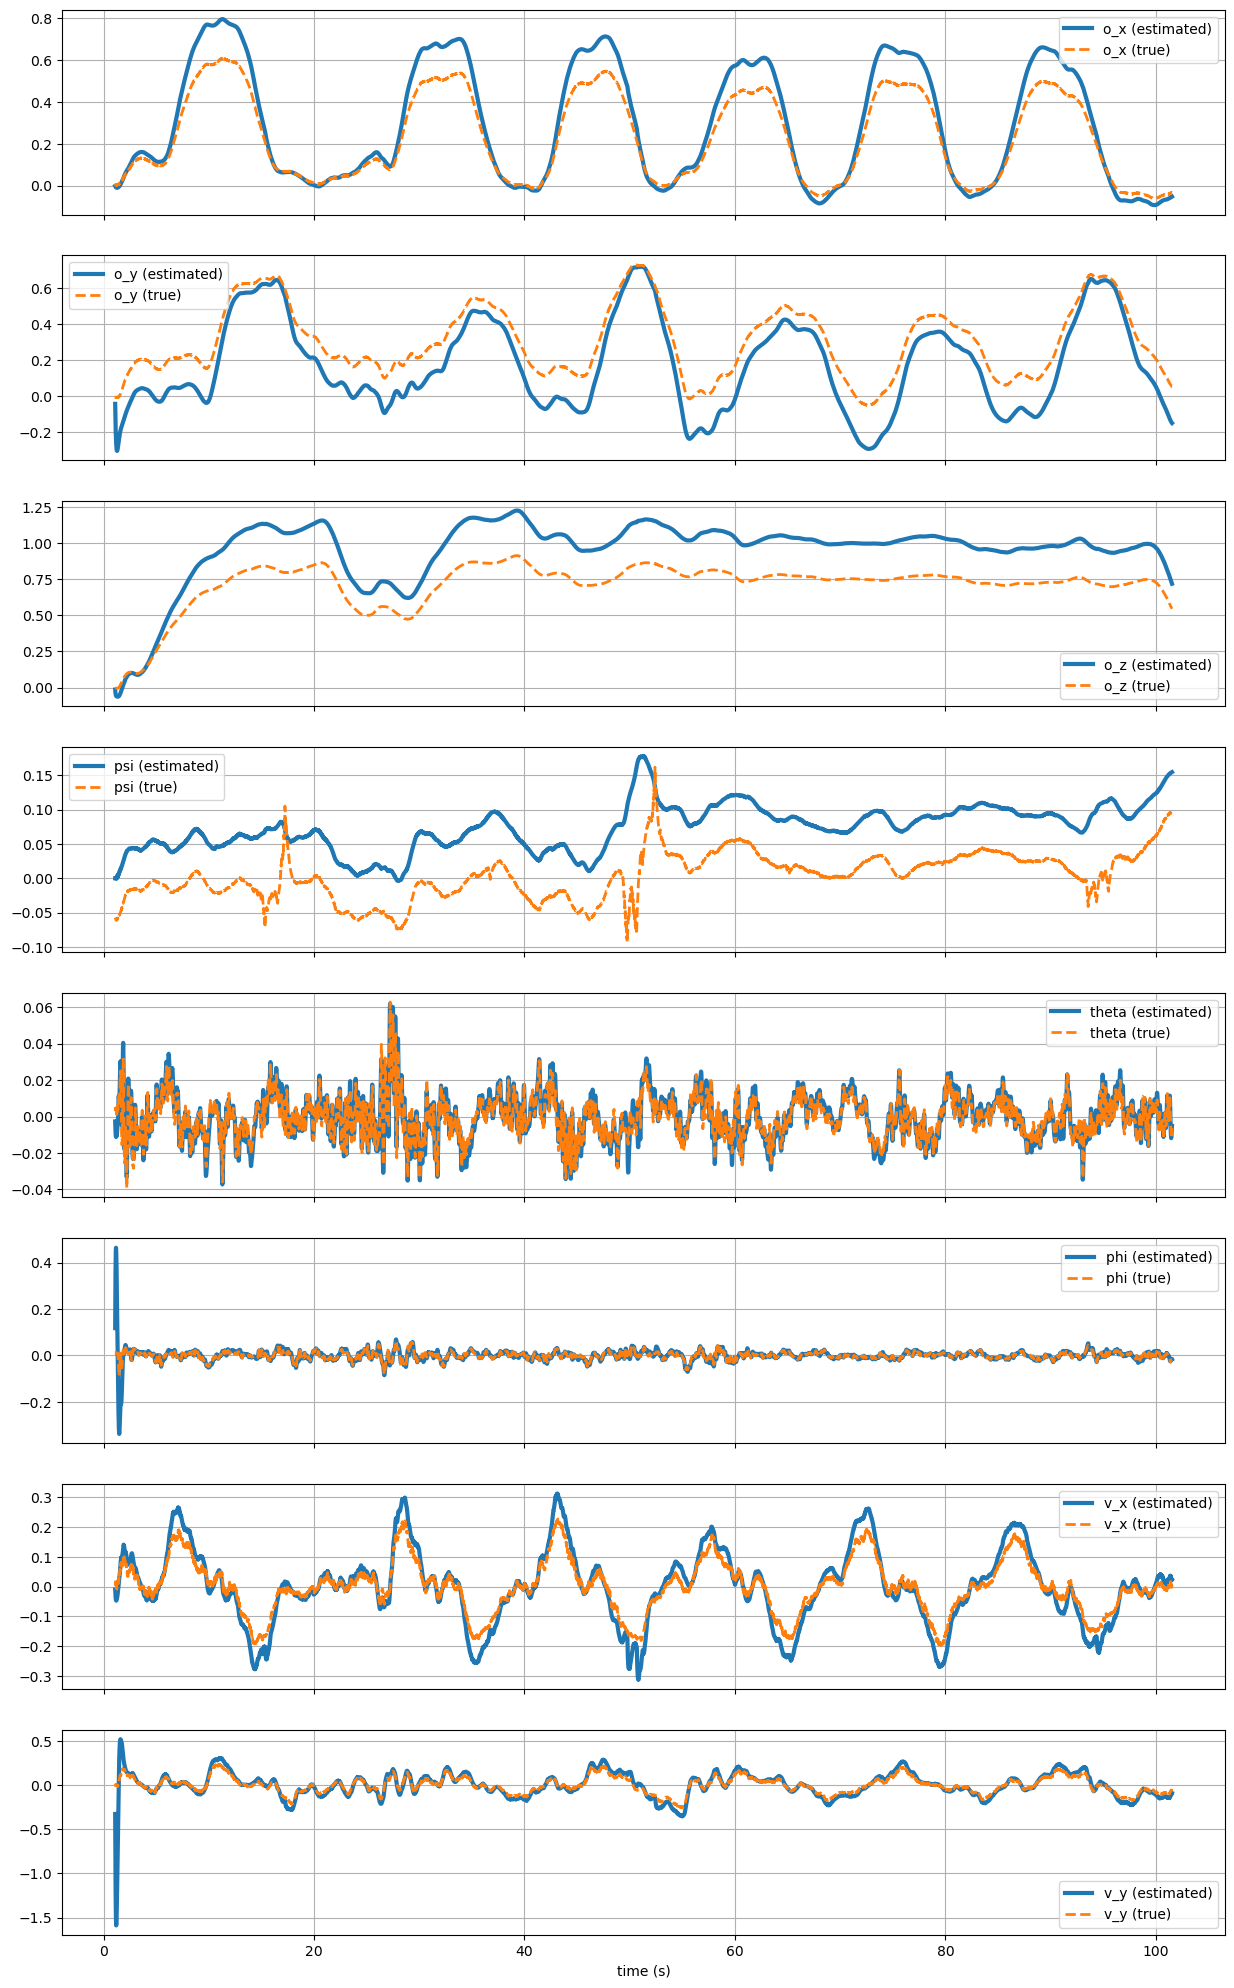

In [234]:
def comparison_plot(t, s_hat, s_true, name, ax):
    ax.plot(t, s_hat, label=f'{name} (estimated)', linewidth=3)
    ax.plot(t, s_true, '--', label=f'{name} (true)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y) = plt.subplots(8, 1, figsize=(15, 25), sharex=True)
comparison_plot(t, o_x_hat, o_x_true, 'o_x', ax_o_x)
comparison_plot(t, o_y_hat, o_y_true, 'o_y', ax_o_y)
comparison_plot(t, o_z_hat, o_z_true, 'o_z', ax_o_z)
comparison_plot(t, psi_hat, psi_true, 'psi', ax_psi)
comparison_plot(t, theta_hat, theta_true, 'theta', ax_theta)
comparison_plot(t, phi_hat, phi_true, 'phi', ax_phi)
comparison_plot(t, v_x_hat, v_x_true, 'v_x', ax_v_x)
comparison_plot(t, v_y_hat, v_y_true, 'v_y', ax_v_y)
ax_v_y.set_xlabel('time (s)')
plt.show()

Plot error in each state estimate with respect to ground truth.

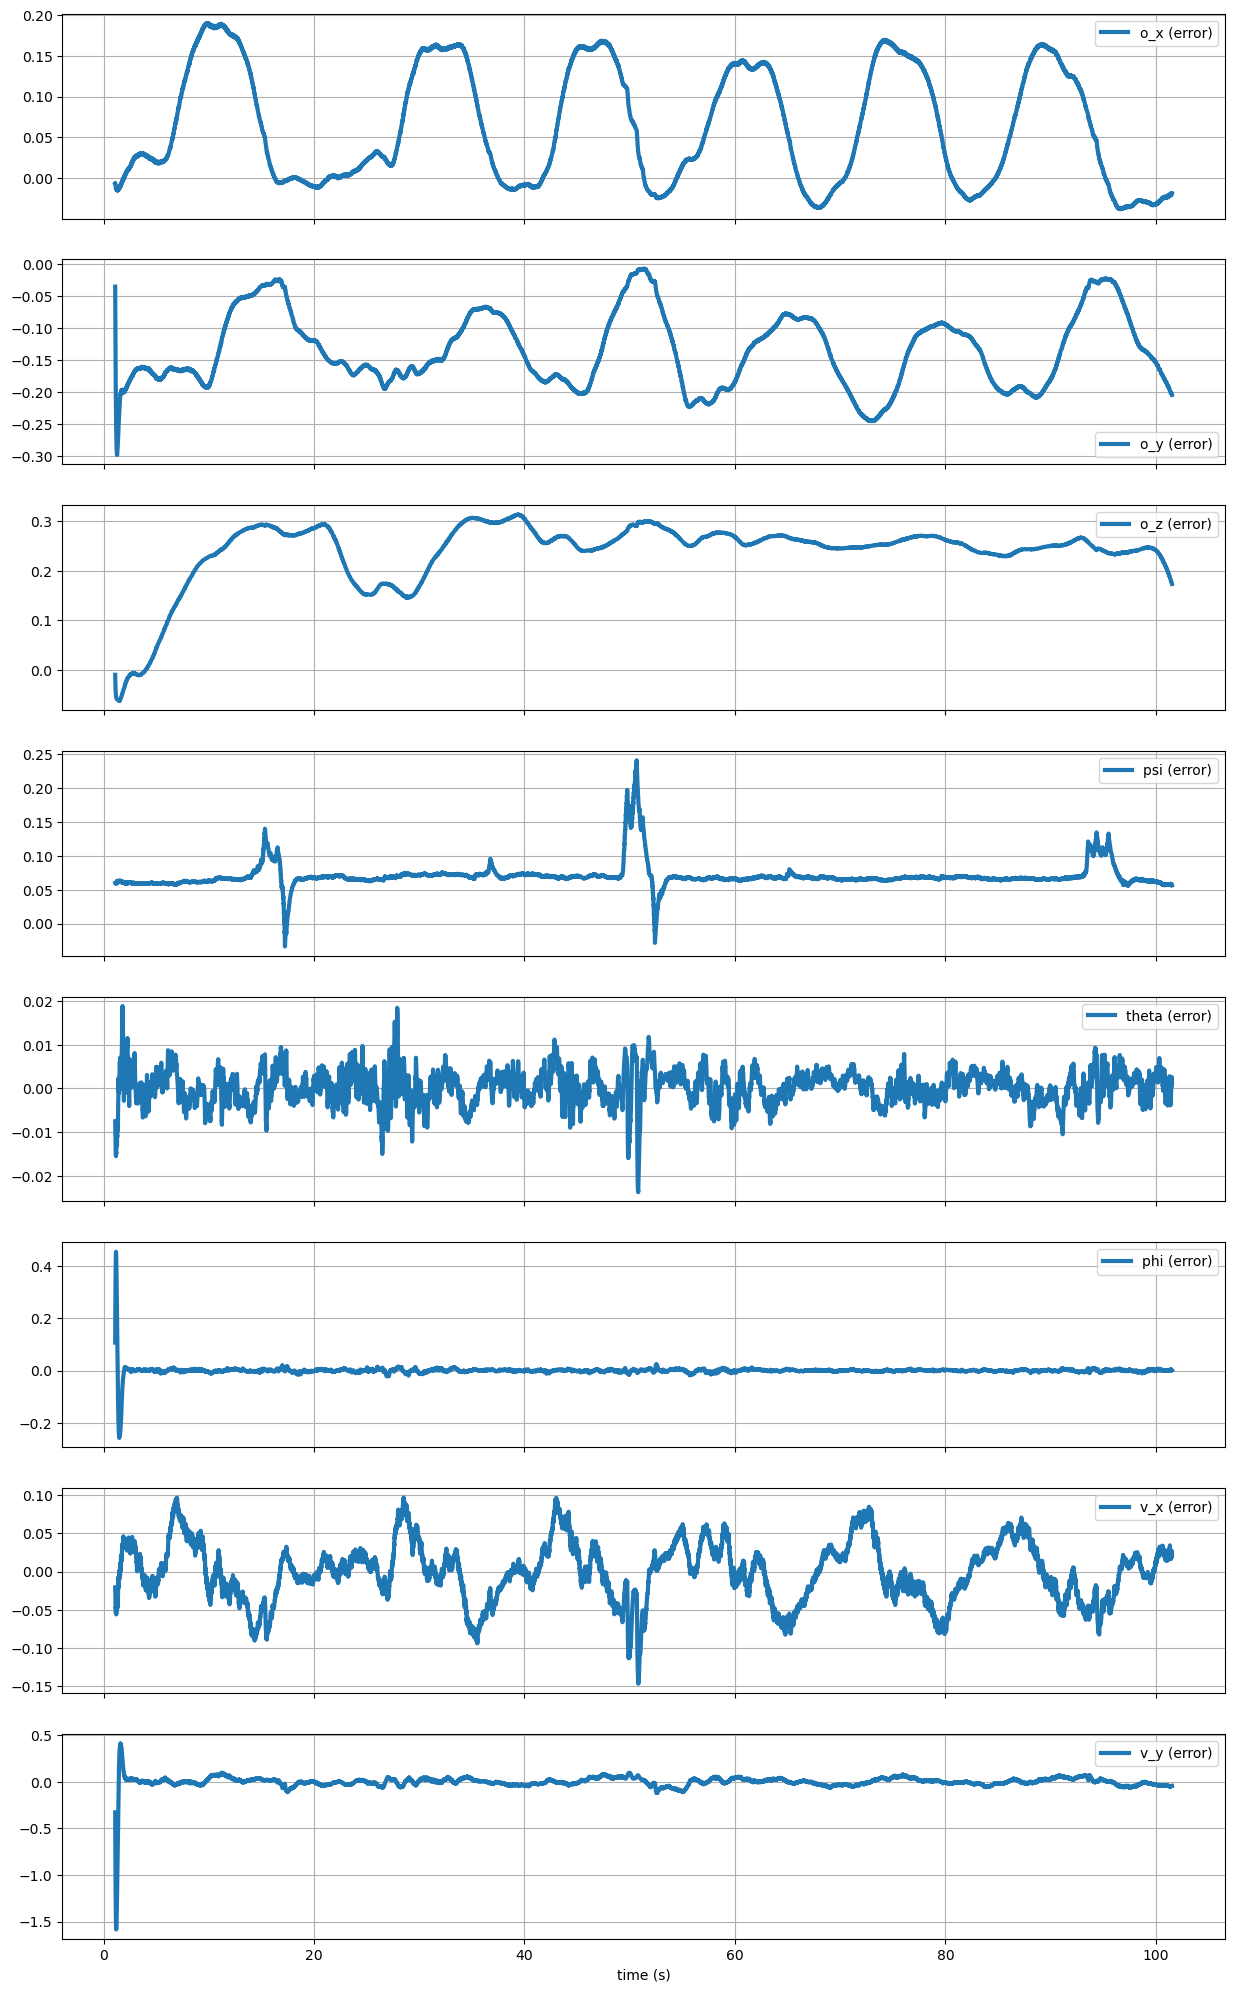

In [235]:
def error_plot(t, s_err, name, ax):
    ax.plot(t, s_err, label=f'{name} (error)', linewidth=3)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y) = plt.subplots(8, 1, figsize=(15, 25), sharex=True)
error_plot(t, o_x_err, 'o_x', ax_o_x)
error_plot(t, o_y_err, 'o_y', ax_o_y)
error_plot(t, o_z_err, 'o_z', ax_o_z)
error_plot(t, psi_err, 'psi', ax_psi)
error_plot(t, theta_err, 'theta', ax_theta)
error_plot(t, phi_err, 'phi', ax_phi)
error_plot(t, v_x_err, 'v_x', ax_v_x)
error_plot(t, v_y_err, 'v_y', ax_v_y)
ax_v_y.set_xlabel('time (s)')
plt.show()

Plot histogram of errors in each state estimate.

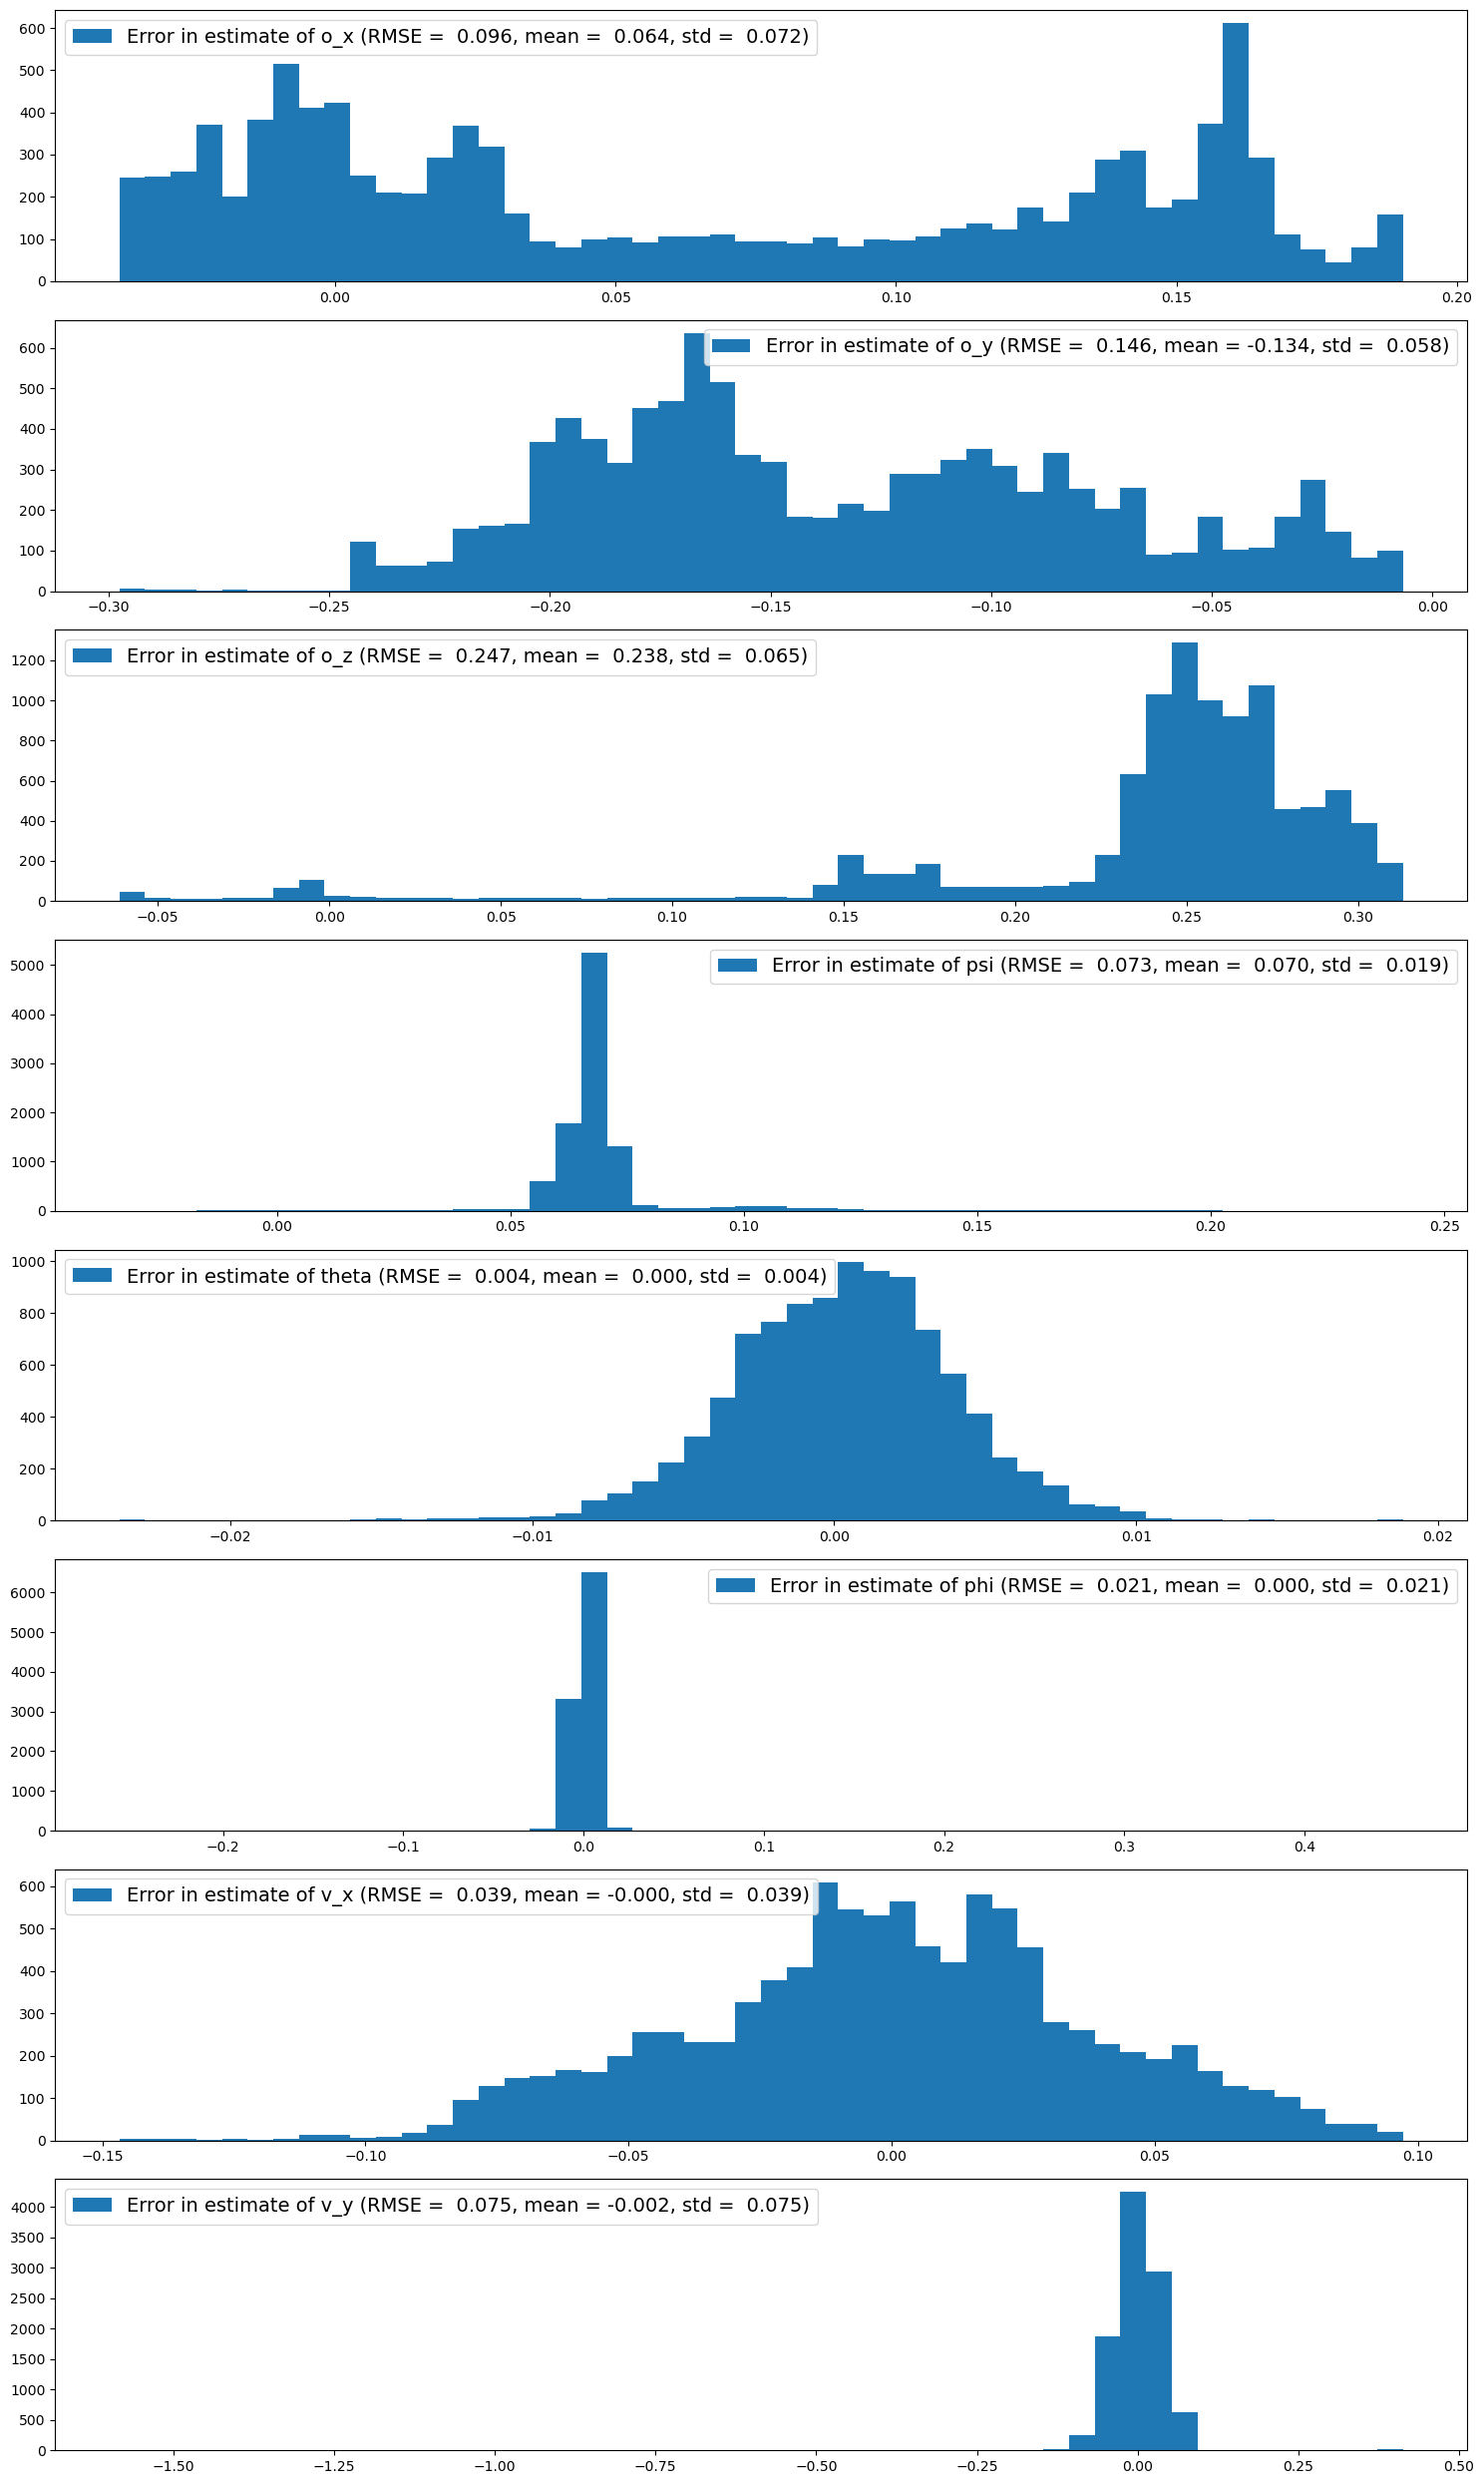

In [236]:
def histogram_plot(t, s_err, name, ax):
    label = f'Error in estimate of {name} ' + \
            f'(RMSE = {np.sqrt(np.mean(s_err**2)):6.3f}, ' + \
            f'mean = {np.mean(s_err):6.3f}, ' + \
            f'std = {np.std(s_err):6.3f})'
    ax.hist(s_err, 50, label=label)
    ax.legend(fontsize=14)

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y) = plt.subplots(8, 1, figsize=(15, 25))
histogram_plot(t, o_x_err, 'o_x', ax_o_x)
histogram_plot(t, o_y_err, 'o_y', ax_o_y)
histogram_plot(t, o_z_err, 'o_z', ax_o_z)
histogram_plot(t, psi_err, 'psi', ax_psi)
histogram_plot(t, theta_err, 'theta', ax_theta)
histogram_plot(t, phi_err, 'phi', ax_phi)
histogram_plot(t, v_x_err, 'v_x', ax_v_x)
histogram_plot(t, v_y_err, 'v_y', ax_v_y)
fig.tight_layout()
plt.show()

# 15. Flight test while moving in squares with ONLINE observer

Load and parse flight test data.

In [237]:
# flight test data
data = load_hardware_data('results/squares.json', only_in_flight=True)

# times
t = data['time']

# position and orientation from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = -np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])

# position and orientation from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Plot position, desired position, and orientation (both from default and custom observer) **over the entire flight test**.

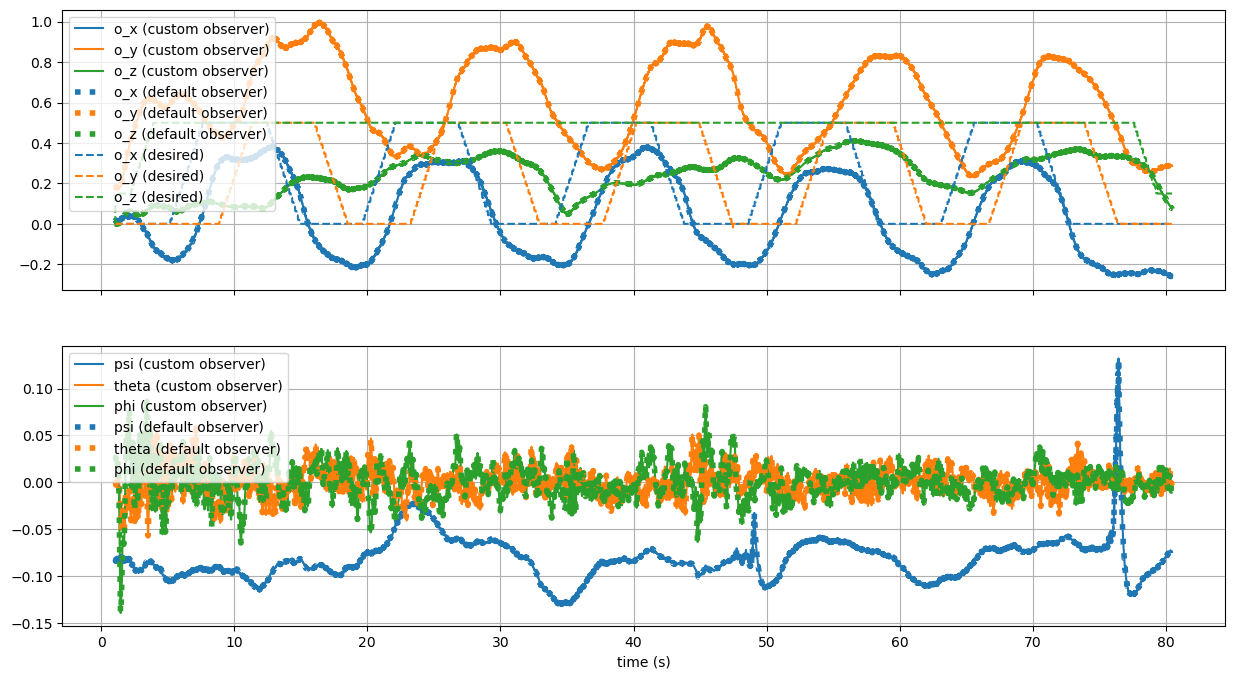

In [238]:
fig, (ax_pos, ax_ori) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
px = ax_pos.plot(t, o_x_custom, label=f'o_x (custom observer)')
py = ax_pos.plot(t, o_y_custom, label=f'o_y (custom observer)')
pz = ax_pos.plot(t, o_z_custom, label=f'o_z (custom observer)')
ax_pos.plot(t, o_x_default, ':', label=f'o_x (default observer)', color=px[0].get_color(), linewidth=4)
ax_pos.plot(t, o_y_default, ':', label=f'o_y (default observer)', color=py[0].get_color(), linewidth=4)
ax_pos.plot(t, o_z_default, ':', label=f'o_z (default observer)', color=pz[0].get_color(), linewidth=4)
ax_pos.plot(t, o_x_des, '--', label=f'o_x (desired)', color=px[0].get_color())
ax_pos.plot(t, o_y_des, '--', label=f'o_y (desired)', color=py[0].get_color())
ax_pos.plot(t, o_z_des, '--', label=f'o_z (desired)', color=pz[0].get_color())
ax_pos.legend()
ax_pos.grid()
ppsi = ax_ori.plot(t, psi_custom, label=f'psi (custom observer)')
ptheta = ax_ori.plot(t, theta_custom, label=f'theta (custom observer)')
pphi = ax_ori.plot(t, phi_custom, label=f'phi (custom observer)')
ax_ori.plot(t, psi_default, ':', label=f'psi (default observer)', color=ppsi[0].get_color(), linewidth=4)
ax_ori.plot(t, theta_default, ':', label=f'theta (default observer)', color=ptheta[0].get_color(), linewidth=4)
ax_ori.plot(t, phi_default, ':', label=f'phi (default observer)', color=pphi[0].get_color(), linewidth=4)
ax_ori.legend()
ax_ori.grid()
ax_ori.set_xlabel('time (s)')
plt.show()

Plot top-down position and desired position (both from default and custom observer).

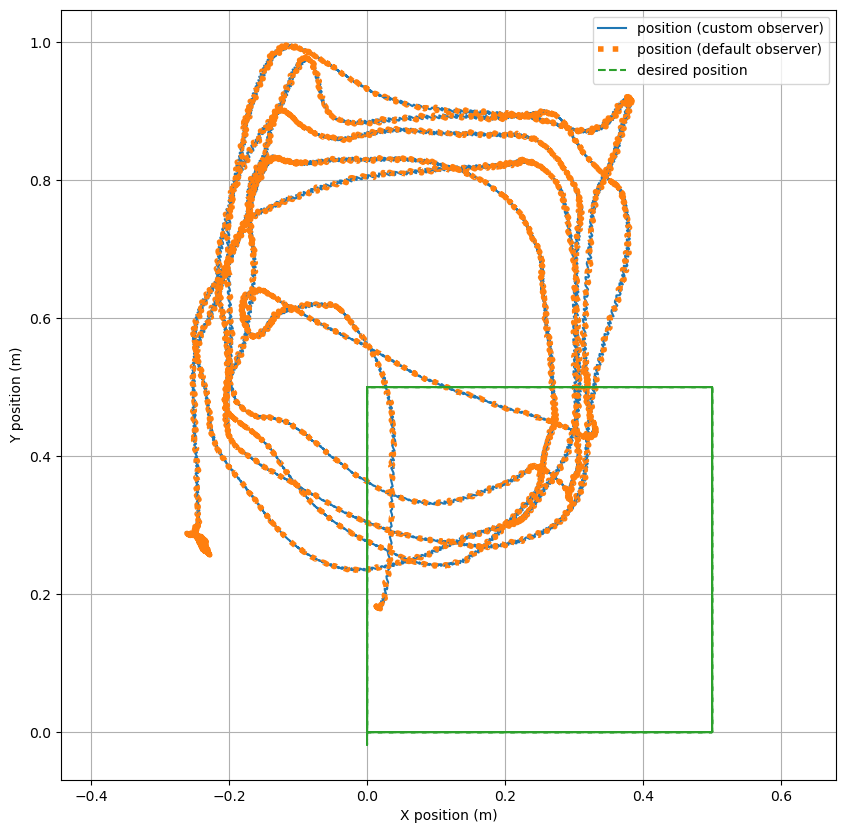

In [239]:
plt.figure(figsize=(10, 10))
plt.plot(o_x_custom, o_y_custom, label='position (custom observer)')
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.legend()
plt.grid()
plt.savefig('results/squares.png', dpi=400)
plt.show()

# 16. View log data for a given drawing

## 16.1 Bottom-up video of drone drawing a star

A star was passed into the edge detector to generate the move commands that result in the flight shown below. The drone was flown using the custom controller and custom observer.

In [240]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_gpr84lfm')

## 16.2 Load in flight data

In [224]:
data = load_hardware_data(
    'results/hardware_data.json', # <-- replace with name of file with hardware data
    t_min_offset=0.,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=0.,      # <-- (optional) replace with how many seconds of data to ignore at end
    only_in_flight=True
)

In [225]:
# time
t = data['time']

# position
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# orientation
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']

# Inputs
x_meas = data['ae483log.x_meas']
y_meas = data['ae483log.y_meas']
z_meas = data['ae483log.z_meas']

# Velocities
v_x = data['ae483log.v_x']
v_y = data['ae483log.v_y']
v_z = data['ae483log.v_z']

# motor power commands
m_1 = data['ae483log.m_1']
m_2 = data['ae483log.m_2']
m_3 = data['ae483log.m_3']
m_4 = data['ae483log.m_4']

## 16.3 Look at the $x_{meas}$ data vs the $o_x$ data

This plot should be identical

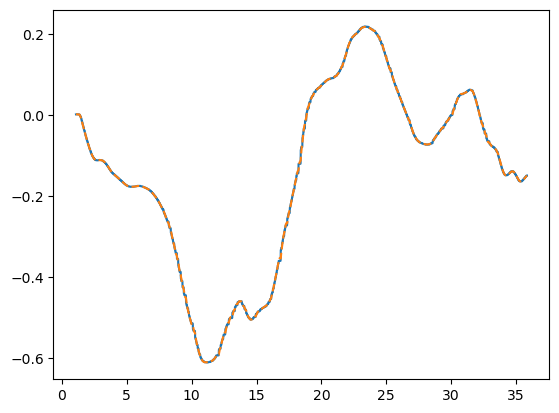

In [226]:
plt.plot(t, x_meas)
plt.plot(t, o_x, linestyle='--')

## 16.4 Look at the $y_{meas}$ vs the $o_y$ data

Again, should be identical lines

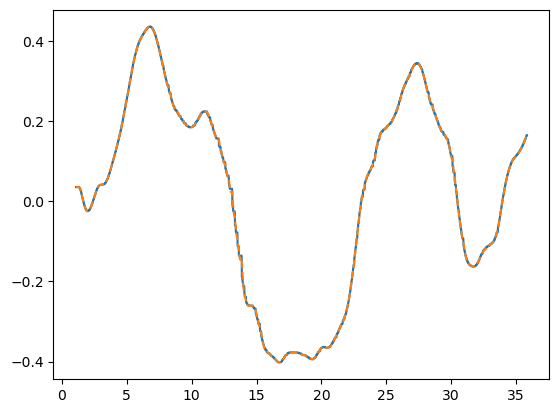

In [227]:
plt.plot(t,y_meas)
plt.plot(t, o_y, linestyle='--')

## 16.5 Look at the $z_{meas}$ vs the $o_z$ data

Should be identical lines

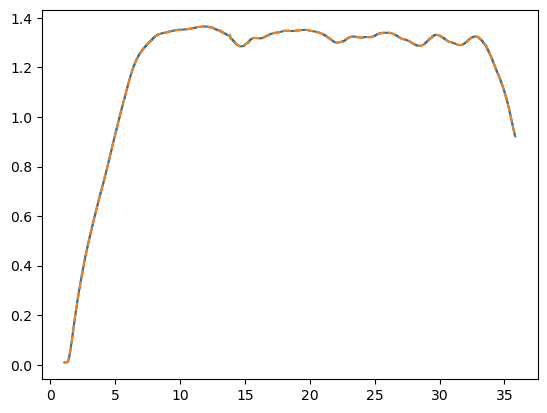

In [228]:
plt.plot(t, z_meas)
plt.plot(t, o_z, linestyle='--')

## 16.6 3-D path of Drone

Should be comparable to the long exposure image generated by the flight

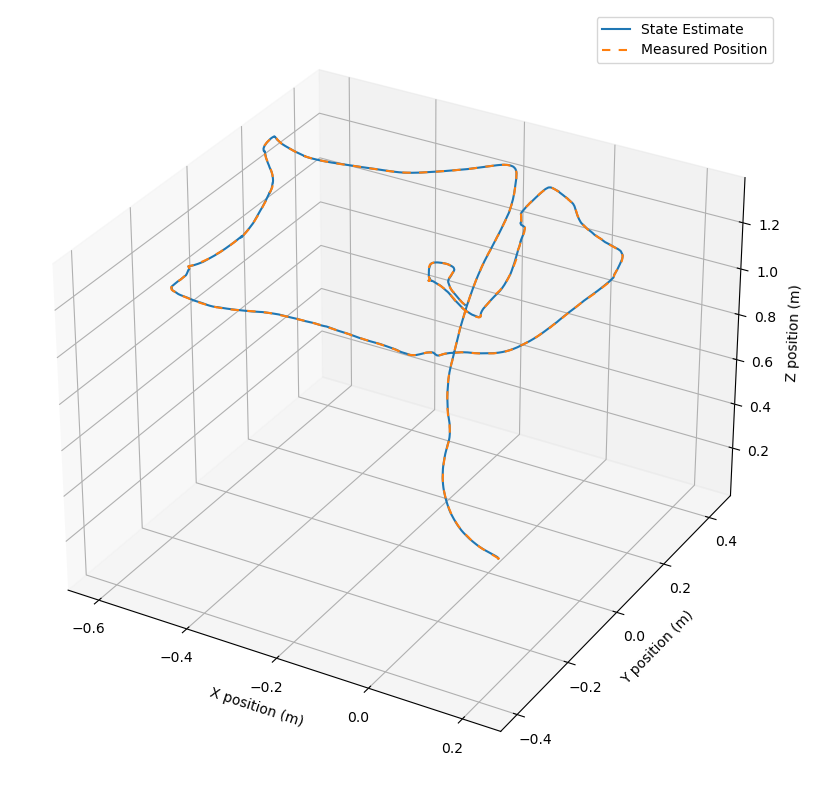

In [229]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.plot(o_x, o_y, o_z, label='State Estimate')
ax.plot(x_meas, y_meas, z_meas, linestyle='--', dashes=(4, 4), label='Measured Position')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend()

plt.savefig('results/star_position_data.png', dpi=400)
plt.show()